# Q9KJX5 EXTRA ANALYSIS

## Libraries, functions and dictionaries

In [1]:
import sys, os

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import random
import seaborn as sns
import re
#import ptitprince as pt

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score


from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from catboost.datasets import titanic
from graphviz import Digraph
from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings('ignore')

In [2]:
alphabetAA_L_D={'-':0,'_' :0,'A':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'K':9,'L':10,'M':11,'N':12,'P':13,'Q':14,'R':15,'S':16,'T':17,'V':18,'W':19,'Y':20}
alphabetAA_D_L={v: k for k, v in alphabetAA_L_D.items()}
               
alphabetAA_3L_1L={"Ter":'*',"Gap":'-',"Ala":'A',"Cys":'C',"Asp":'D',"Glu":'E',"Phe":'F',"Gly":'G',"His":'H',"Ile":'I',"Lys":'K',"Leu":'L',"Met":'M',"Asn":'N',"Pro":'P',"Gln":'Q',"Arg":'R',"Ser":'S',"Thr":'T',"Val" :'V',"Trp":'W',"Tyr":'Y'}
alphabetAA_1L_3L={v: k for k,v in alphabetAA_3L_1L.items()}

alphabetAA_3L_1LC={"Ter":'*',"Gap":'-',"ALA":'A',"CYS":'C',"ASP":'D',"GLU":'E',"PHE":'F',"GLY":'G',"HIS":'H',"ILE":'I',"LYS":'K',"LEU":'L',"MET":'M',"ASN":'N',"PRO":'P',"GLN":'Q',"ARG":'R',"SER":'S',"THR":'T',"VAL" :'V',"TRP":'W',"TYR":'Y'}

alphabetAA_to_classes={'A':1,'C':2,'D':3,'E':3,'F':1,'G':4,'H':3,'I':1,'K':3,'L':1,'M':1,'N':2,'P':4,'Q':2,'R':3,'S':2,'T':2,'V':1,'W':1,'Y':1}
alphabetclasses_to_AA={v: k for k,v in alphabetAA_to_classes.items()}

AA_ddsp_number={'H' :0,'B' : 1,'E' : 2,'G' : 3,'I' : 4,'T' : 5,'S' : 6,' ' : 7}
AA_number_ddsp={v: k for k,v in AA_ddsp_number.items()}

AA_ddsp_number_simp={'H' :0,'E' : 1,'C' : 2}
AA_number_ddsp_simp={v: k for k,v in AA_ddsp_number.items()}

AA_to_hydrophobicity_scores={'A':44,'C':50,'D':-37,'E':-12,'F':96,'G':0,'H':-16,'I':100,'K':-30,'L':99,'M':74,'N':-35,'P':-46,'Q':-14,'R':-20,'S':-6,'T':13,'V':78,'W':90,'Y':57}

### Load functions

In [3]:
def remove_WT_score(score,WT_seq):
    for i in range(len(WT_seq)):
        score[i,alphabetAA_L_D[WT_seq[i]]-1]=np.nan
    return score

In [51]:
def load_data_V2(data,wt_seq,start_gap=0,column_score=1):
    df=pd.read_csv(data, delim_whitespace=True, comment='#')
    mutation_load=np.array(df.iloc[:,0])
    score_load=np.array(df.iloc[:,column_score])
    scores=np.empty((len(wt_seq),20),dtype=float)
    scores[:]=np.nan
    for i in range(len(mutation_load)):
        if  mutation_load[i][len(mutation_load[i])-1]!= '=' and mutation_load[i][len(mutation_load[i])-1]!= '*' :
            scores[int(mutation_load[i][1:len(mutation_load[i])-1])-1+start_gap, alphabetAA_L_D[mutation_load[i][len(mutation_load[i])-1]]-1]= float(score_load[i])
    return scores

### General functions

In [4]:
def normalize_score(scores):
    normalized_scores=np.copy(scores)
    c_min_act=np.percentile(scores[~np.isnan(scores)],5)
    c_max_act=np.percentile(scores[~np.isnan(scores)],95)
    for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
            normalized_scores[i,j]=(scores[i,j]-c_min_act)/(c_max_act-c_min_act)
                                  
    return normalized_scores

In [5]:
def normalize_minmax(scores):
    normalized_scores=np.copy(scores)
    c_min_act=np.amin(scores[~np.isnan(scores)])
    c_max_act=np.amax(scores[~np.isnan(scores)])
    for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
            normalized_scores[i,j]=(scores[i,j]-c_min_act)/(c_max_act-c_min_act)
                                  
    return normalized_scores

In [6]:
def normalize_fermi(scores):
    normalized_scores=np.copy(scores)
    for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
            normalized_scores[i,j]=1/(sp.exp(scores[i,j]-2)+1)                 
    return normalized_scores

In [7]:
def normalize_cutoff(scores,lowcut,highcut):
    normalized_scores=np.copy(scores)
    for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
            if scores[i,j] < lowcut:
                normalized_scores[i,j]=lowcut
            elif scores[i,j] > highcut:
                normalized_scores[i,j]=highcut
            else:
                normalized_scores[i,j]=scores[i,j]
    return normalized_scores

In [8]:
def position_mean(score):
    score_mean=np.zeros(score.shape[0],dtype=float)
    for i in range(score.shape[0]):
        count=0
        flag_nan=True
        for j in range(score.shape[1]):
            if np.isnan(score[i,j])==False:
                flag_nan=False
                score_mean[i]+=score[i,j]
                count+=1
            else:
                pass
        if flag_nan==True:
            score_mean[i]=np.nan
        score_mean[i]/=count
        
    return score_mean

In [9]:
def score_histogram(score,nbin,color,label_x,norm_bool,thr):

    counts, bins = np.histogram(score[~np.isnan(score)],bins=nbin)
    if norm_bool=='Density':
        n, bins, patches = plt.hist(score[~np.isnan(score)], bins=nbin, facecolor=color, alpha=0.7,edgecolor="black",density=True)
        plt.ylabel('Normalized counts',fontsize=20)
    elif norm_bool=='True':
        
        norm= counts / np.linalg.norm(counts)
        plt.hist(bins[:-1], bins, weights=norm, facecolor=color, alpha=0.7,edgecolor="black")
        plt.ylabel('Normalized counts',fontsize=20)
    else:
        n, bins, patches = plt.hist(score[~np.isnan(score)], bins=nbin, facecolor=color,edgecolor="black")
        plt.ylabel('Counts',fontsize=20)

    plt.xlabel(label_x,fontsize=20)
    plt.xticks(fontsize=18)
    plt.grid(axis="y",alpha=0.4,linestyle='--')
    sum_unstable=0
    for i in range(len(bins)-1):
        if bins[i+1] < thr:
            sum_unstable+=counts[i]
    print('Wt-like variants:',np.sum(counts)-sum_unstable, ' (', (np.sum(counts)-sum_unstable)/np.sum(counts) ,')')
    
    #plt.show()

In [10]:
def heatmap_IBS(prediction,variant_map,WT):
    scores=np.empty((len(WT),20),dtype=float)
    scores[:]=np.nan
    
    i=0
    for cord in variant_map:
        scores[cord[0],cord[1]]=prediction[i]
        i+=1

    fig, ax = plt.subplots(figsize=(16,6))
    ylabels=[ alphabetAA_D_L[i] for i in range(1,21)]
    
    ax.imshow(np.transpose(scores), aspect = 'auto', cmap=mpl.colors.ListedColormap(["white","#56b4e9"]))

    ax.set_yticks([i for i in range(0,20)])
    ax.set_yticklabels(ylabels,fontsize=15)
    ax.tick_params(axis='x', which='major', labelsize=15)
        
    tmp=np.empty((len(WT),20),dtype=float)
    tmp[:]=np.inf
    for i in range(0,len(WT)):
        tmp[i,alphabetAA_L_D[WT[i]]-1]=1
    plt.imshow(tmp.T, cmap='Accent', aspect = 'auto')
    
    plt.grid(axis='both',which='both',alpha=0.4)
    plt.ylabel("mutation",fontsize=16)
    plt.xlabel("residue",fontsize=16)

    plt.ylim(-0.5,19.5)

In [11]:
def ratio_variants(mave_funct,mave_abd):
    ratio=np.copy(mave_funct)
    ratio[:]=np.nan
    for i in range(ratio.shape[0]):
        for j in range(ratio.shape[1]):
            if np.isnan(mave_funct[i,j]) or np.isnan(mave_abd[i,j]):
                pass
            else:
                if mave_abd[i,j]==0.0:
                    ratio[i,j]=mave_funct[i,j]/0.0000001
                else:
                    ratio[i,j]=mave_funct[i,j]/mave_abd[i,j]
    sig_ratio=np.copy(ratio)
    sig_ratio[:]=np.nan
    for i in range(ratio.shape[0]):
        for j in range(ratio.shape[1]):
            if np.isnan(ratio[i,j])!=True:
                sig_ratio[i,j]=1/(1+np.exp(-(ratio[i,j]-1)))

    return sig_ratio

In [12]:
def MCC_test_subset(prediction,test):
    TP=0
    FP=0
    total=0
    for i in range(len(prediction)):
        if np.isnan(prediction[i])!= True and np.isnan(test[i])!=True:
            if prediction[i]==1:
                if int(prediction[i])==int(test[i]):
                    TP+=1
                else:
                    FP+=1
            if int(test[i])==1:
                total+=1
    precision=TP/(TP+FP)
    recall=TP/total
    mcc=np.sqrt(abs(precision*recall))
    
    return precision,recall,mcc                 

In [13]:
def AUC_subset(prediction,test):
    TP=0
    FP=0
    FN=0
    TN=0
    
    for i in range(len(prediction)):
        if np.isnan(prediction[i])!= True and np.isnan(test[i])!=True:
            if prediction[i]==1:
                if int(prediction[i])==int(test[i]):
                    TP+=1
                else:
                    FP+=1
            if prediction[i]==0:
                if int(prediction[i])==int(test[i]):
                    TN+=1
                else:
                    FN+=1 
                    
    TPR=TP/(TP+FN)
    FPR=FP/(FP+TN)
    
    return [TPR,FPR]

In [14]:
def retrieve_residue_label_pred_training(prediction,variant_map,WT,percentage_threshold):
    scores=np.empty((len(WT),20),dtype=float)
    scores[:]=np.nan
    
    i=0
    for cord in variant_map:
        scores[cord[0],cord[1]]=prediction[i]
        i+=1
    pseudomode_value_class=np.empty(len(WT),dtype=float)
    pseudomode_value_class[:]=np.nan
    percentage_mode=np.zeros((len(WT),2),dtype=float)
    
    for i in range(len(pseudomode_value_class)):
        count=0
        for j in range(scores.shape[1]):
            if np.isnan(scores[i,j])!=True:
                count+=1
        if count>0:
            count_1=0
            for j in range(scores.shape[1]):
                if scores[i,j]==1:
                    count_1+=1
            percentage=count_1/count
            
            if percentage > percentage_threshold:
                pseudomode_value_class[i]=1
            else:
                pseudomode_value_class[i]=0
            
            percentage_mode[i,0]=percentage
            percentage_mode[i,1]=count
    
    #mode_value_class, counts_mode=sp.stats.mode(scores,axis=1,nan_policy='omit')
    
    return pseudomode_value_class,percentage_mode

In [15]:
def retrieve_residue_label_pred(prediction,variant_map,WT,percentage_threshold):
    scores=np.empty((len(WT),20),dtype=float)
    scores[:]=np.nan
    
    i=0
    for cord in variant_map:
        scores[cord[0],cord[1]]=prediction[i]
        i+=1
    
    count_pos=np.zeros((len(WT),4),dtype=float)
    
    pseudomode_value_class=np.empty(len(WT),dtype=float)
    pseudomode_value_class[:]=np.nan
    percentage=np.zeros((len(WT),2),dtype=float)
        
    for i in range(len(pseudomode_value_class)):
        count=0
        for j in range(scores.shape[1]):
            if np.isnan(scores[i,j])!=True:
                count+=1
        if count>0:
            for j in range(scores.shape[1]):
                    if np.isnan(scores[i,j])!=True:
                        count_pos[i,int(scores[i,j])]+=1
            count_pos=count_pos/count
            if np.any(count_pos[i,:]>=0.50):
                pseudomode_value_class[i]=np.argmax(count_pos[i,:])
                percentage[i,0]=count_pos[i,1]
                #print(i, count_pos[i,:],np.max(count_pos[i,:]),np.argmax(count_pos[i,:]),pseudomode_value_class[i])


            else:                
                pseudomode_value_class[i]=5
                percentage[i,0]=count_pos[i,1]
                #print(i, count_pos[i,:],np.max(count_pos[i,:]),np.argmax(count_pos[i,:]),'else',pseudomode_value_class[i])
                ## 5 indicates mixed signal with no predominat mutation class
            
            percentage[i,1]=count
    
    #mode_value_class, counts_mode=sp.stats.mode(scores,axis=1,nan_policy='omit')
    
    return pseudomode_value_class,percentage

In [16]:
def pairplot_features(list_feature,name_features,namefile):
    df=pd.DataFrame(list_feature,columns=name_features)
    sns_plot=sns.pairplot(df)
    sns_plot.savefig(namefile)

In [17]:
def print_chimera_x_attribute_file(attribute_check,attribute,file):
    file=open(file,"w+")
    file.write('%s\n%s\n%s\n%s\n' % ('#','#  Use this file to assign the attribute in Chimera with the','#  Define Attribute tool or the command defattr','#'))
    file.write('%s\n%s\n%s\n' % ( 'attribute: cbyvalue','match mode: 1-to-1', 'recipient: residues') )
    for i in range(len(attribute_check)):
        if np.isnan(attribute_check[i])==True:
            pass
        else:
            file.write("\t%s%d\t%f\n" % ('/A:',i+1,attribute[i]))
    file.close()

In [18]:
def print_chimera_x_attribute_file_SBI(attribute_check,attribute,file):
    file=open(file,"w+")
    file.write('%s\n%s\n%s\n%s\n' % ('#','#  Use this file to assign the attribute in Chimera with the','#  Define Attribute tool or the command defattr','#'))
    file.write('%s\n%s\n%s\n' % ( 'attribute: cbyvalue','match mode: 1-to-1', 'recipient: residues') )
    for i in range(len(attribute_check)):
        if np.isnan(attribute_check[i])==True:
            pass
        else:
            if attribute_check[i]==1.0:
                file.write("\t%s%d\t%f\n" % ('/A:',i+1,1))
            else:
                file.write("\t%s%d\t%f\n" % ('/A:',i+1,0))
    file.close()

In [19]:
def plot_attributes(pos,pred,variant_map,gemme,rosetta,wcn,gemme_n,rosetta_n):
    
    label_position=np.empty(20,dtype=float)
    label_position[:]=np.nan
    
    i=0
    for cord in variant_map:
        if cord[0]==pos:
            label_position[cord[1]]=prediction[i]
        i+=1
    
    fig,(ax1,ax2,ax3,ax4,ax5,ax6)=plt.subplots(1,6,figsize=(9,4),gridspec_kw={"width_ratios" : [7,1,1,1,1,1], "wspace" : 0.4})
    cdict = {1: 'blue', 0: 'red'}
    glabel={1.0:'SBI',0.0:'non-SBI'}
    for g in np.unique(label_position):
        if np.isnan(g)!=True:
            ix = np.where(label_position == g)
            ax1.scatter(rosetta[pos,ix],gemme[pos,ix],c=cdict[g], label=[glabel[g]])
    
    ax2.bar(x=0.5,height=wcn[pos])
    ax3.bar(x=0.5,height=np.mean(gemme[pos,:][~np.isnan(gemme[pos,:])]))
    ax4.bar(x=0.5,height=np.mean(rosetta[pos,:][~np.isnan(rosetta[pos,:])]))   
    ax5.bar(x=0.5,height=gemme_n[pos])
    ax6.bar(x=0.5,height=rosetta_n[pos])
    
    
    ax1.set_title('variants classification')
    ax2.set_title('WCN')
    ax3.set_title(r'$\bar{G}$')
    ax4.set_title(r'$\bar{r}$')
    ax5.set_title(r'G_n')
    ax6.set_title(r'r_n')
    
    ax1.set_xlabel('rosetta_score',fontsize=13)
    ax1.set_ylabel('GEMME score',fontsize=13)
    ax1.set_xlim(6,-1)
    ax1.set_ylim(-7,1)
    ax2.set_ylim(0,15)
    ax3.set_ylim(0,-8)
    ax4.set_ylim(0,6)
    ax5.set_ylim(0,-8)
    ax6.set_ylim(0,6)
    
    
    ax2.set_xticks([],[])
    ax3.set_xticks([],[])
    ax4.set_xticks([],[])
    ax5.set_xticks([],[])
    ax6.set_xticks([],[])
    ax2.set_xlim(0.1,0.9)
    
    
    
    ax1.legend()

In [20]:
def results_plot(MCC,AUC,name_models):
    
    fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(14,4))
    
    cdict = {1: '#355070', 2: '#6D597A',2:'#B56576',3 :'#a4d600',4:'#a47f4b',5:'#EAAC8B',6:'#4a944f',7:"#F95738"}
    for g in range(0,7):
        ax1.scatter(AUC[g,1],AUC[g,0],c=cdict[g+1])
    ax1.plot([0, 1], [0, 1], transform=ax1.transAxes,ls=':')
    ax1.set_xlabel('FPR',fontsize=13)
    ax1.set_ylabel('TPR',fontsize=13)
    
    for g in range(0,7):
        ax2.scatter(MCC[g,0],MCC[g,1],c=cdict[g+1], label=g+1)
    #ax2.scatter(MCC[:,0],MCC[:,1],c=color_class)
    
    ax2.set_xlabel('Precision',fontsize=13)
    ax2.set_ylabel('Recall',fontsize=13)
    ax2.legend(loc='lower right')
    
    cbar=[cdict[i] for i in range(1,8)]
    ax3.bar(name_models,MCC[:,2],color=cbar)
    ax3.set_ylabel('MCC',fontsize=13)


In [21]:
def print_percentage_prediction(pred,mode_pred,WT,WT_ros):
    effective_pos=0
    for i in range(len(WT)):
        if WT[i]==WT_ros[i]:
            effective_pos+=1
    count_SBI=0
    for i in pred:
        if i ==1:
            count_SBI+=1
    
    print(f' SBI variants: {count_SBI} out of {len(pred)} ({count_SBI/len(pred)*100:.2f}%) ')
    
    perc_variants=count_SBI/len(pred)*100
    
    count_SBI=0
    for i in mode_pred:
        if i==1:
            count_SBI+=1
    print(f' SBI residues: {count_SBI} out of {effective_pos} ({count_SBI/effective_pos*100:.2f}%) ')
    
    return [perc_variants, count_SBI/effective_pos*100]

In [22]:
def print_numbers_prediction(pred,mode_pred,WT,WT_ros):
    effective_pos=0
    for i in range(len(WT)):
        if WT[i]==WT_ros[i]:
            effective_pos+=1
    count_SBI=0
    for i in pred:
        if i ==1:
            count_SBI+=1
    
    variants=count_SBI
    
    count_SBI=0
    for i in mode_pred:
        if i==1:
            count_SBI+=1
    
    return [variants, count_SBI]

### setup ML functions

In [23]:
def WCN(pdb_loc,scheme_e,WT):
    r0=7.0
    pdb=md.load(pdb_loc)
    topology=pdb.topology
    chainA=topology.select('chainid 0 and protein')
    pdb_chain0=pdb.atom_slice(chainA)
    pdb_dist,pdb_rp=md.compute_contacts(pdb_chain0,scheme=scheme_e,periodic=False)
    
    cm= md.geometry.squareform(pdb_dist,pdb_rp)[0]
    wcn=np.zeros((len(WT)),dtype=float)
    
    cm_adj=np.empty((len(WT),len(WT)),dtype=float)
    cm_adj[:]=np.nan
    chainA_top=pdb_chain0.topology
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i==0 and j==0:
                print(str(chainA_top.residue(i)))
            cm_adj[int(str(chainA_top.residue(i))[3:])-1,int(str(chainA_top.residue(j))[3:])-1]=cm[i,j]
    for i in range(len(WT)):
        nan_flag=True
        for j in range(len(WT)):
            if np.isnan(cm_adj[i,j])!=True and cm_adj[i,j]!=0.0:
                nan_flag=False
                wcn[i]+=(1-(cm_adj[i,j]*10/r0)**6)/(1-(cm_adj[i,j]*10/r0)**12)
        if nan_flag==True:
            wcn[i]=np.nan
    return wcn

In [24]:
def neighbor_scores(score,ext_range):
    score_neighborhood=np.zeros(len(score),dtype=float)
    for i in range(len(score)):
        if np.isnan(score[i])!=True:
            count_nan=0
            if i==0:
                for j in range(1,ext_range+1):
                    if np.isnan(score[j])==False:
                        score_neighborhood[i]+=score[j]
                    else:
                        count_nan+=1
                if count_nan!=ext_range:    
                    score_neighborhood[i]/=(ext_range)
                else:
                    score_neighborhood[i]=np.nan

            elif i==(len(score)-1):
                for j in range(len(score)-1-ext_range,len(score)-1):
                    if np.isnan(score[j])==False:
                        score_neighborhood[i]+=score[j]
                    else:
                        count_nan+=1
                if count_nan!=ext_range: 
                    score_neighborhood[i]/=ext_range
                else:
                    score_neighborhood[i]=np.nan                
            elif i<ext_range:
                for j in range(0,i+ext_range+1):
                    if j!=i:
                        if np.isnan(score[j])==False:
                            score_neighborhood[i]+=score[j]
                        else:
                            count_nan+=1
                if count_nan!=(i+ext_range):    
                    score_neighborhood[i]/=(i+ext_range)
                else:
                    score_neighborhood[i]=np.nan                        

            elif i>(len(score)-1-ext_range):
                for j in range(i-ext_range,len(score)):
                    if j!=i:
                        if np.isnan(score[j])==False:
                            score_neighborhood[i]+=score[j]
                        else:
                            count_nan+=1
                if count_nan!=(len(score)-i+ext_range):                     
                    score_neighborhood[i]/=(len(score)-i+ext_range)
                else:
                    score_neighborhood[i]=np.nan  
            else:
                for j in range(i-ext_range,i+ext_range+1):
                    if j!=i:
                        if np.isnan(score[j])==False:
                            score_neighborhood[i]+=score[j]
                        else:
                            count_nan+=1
                if count_nan!=(2*ext_range):  
                    score_neighborhood[i]/=(2*ext_range)
                else:
                    score_neighborhood[i]=np.nan             
        else:
            score_neighborhood[i]=np.nan
    return score_neighborhood

In [25]:
def label_category(output,threshold):
    labels=[]
    if output.ndim==1:
        labels=np.copy(output)
        labels[:]=np.nan
        for i in range(len(output)):
            if output[i]<threshold:
                labels[i]=0
            else:
                labels[i]=1
    else:
        labels=np.copy(output)
        labels[:]=np.nan
        for i in range(output.shape[0]):
            for j in range(output.shape[1]):
                if output[i,j]<threshold:
                    labels[i,j]=1
                else:
                    labels[i,j]=0
    return labels

In [26]:
def features_classification(list_features_x,list_output_y,WT):
    
    X=[]
    Y=[]
    mapping_pos=[] 
    
    for i in range(len(WT)):
        for j in range(20):
            if j!=(alphabetAA_L_D[WT[i]]-1):
                temp_x=[]
                temp_y=[]
                cond=True

                for elem in list_features_x:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False    
                
                for elem in list_output_y:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False 

                if cond==True:
                    
                    for elem in list_features_x:
                        if elem.ndim==1:
                            temp_x.append(elem[i])
                        else:
                            temp_x.append(elem[i,j])

                    for elem in list_output_y:
                        if elem.ndim==1:
                            temp_y.append(elem[i])
                        else:
                            temp_y.append(elem[i,j])
                    
                if len(temp_x)>0:
                    X.append(temp_x)
                    Y.append(temp_y)
                    mapping_pos.append([i,j])
        
    return np.array(X),Y,mapping_pos        

In [27]:
def features_classification(list_features_x,list_output_y,WT):
    
    X=[]
    Y=[]
    mapping_pos=[] 
    
    for i in range(len(WT)):
        for j in range(20):
            if j!=(alphabetAA_L_D[WT[i]]-1):
                temp_x=[]
                temp_y=[]
                cond=True

                for elem in list_features_x:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False    
                
                for elem in list_output_y:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False 

                if cond==True:
                    
                    for elem in list_features_x:
                        if elem.ndim==1:
                            temp_x.append(elem[i])
                        else:
                            temp_x.append(elem[i,j])

                    for elem in list_output_y:
                        if elem.ndim==1:
                            temp_y.append(elem[i])
                        else:
                            temp_y.append(elem[i,j])
                    
                if len(temp_x)>0:
                    X.append(temp_x)
                    Y.append(temp_y)
                    mapping_pos.append([i,j])
        
    return np.array(X),Y,mapping_pos        

In [28]:
def features_validation(list_features_x,WT):
    
    X=[]
    mapping_pos=[] 
    
    for i in range(len(WT)):
        for j in range(20):
            if j!=(alphabetAA_L_D[WT[i]]-1):
                temp_x=[]
                temp_y=[]
                cond=True

                for elem in list_features_x:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False    
            

                if cond==True:
                    
                    for elem in list_features_x:
                        if elem.ndim==1:
                            temp_x.append(elem[i])
                        else:
                            temp_x.append(elem[i,j])
                    
                if len(temp_x)>0:
                    X.append(temp_x)
                    mapping_pos.append([i,j])
        
    return np.array(X),mapping_pos        

In [29]:
def binary_threshold(data_x,data_y,t_x,t_y):
    labels=np.copy(data_x)
    labels[:]=np.nan
    
    for i in range(data_x.shape[0]):
        for j in range(data_x.shape[1]):
            if np.isnan(data_x[i,j])!= True and np.isnan(data_y[i,j])!=True:
                if data_x[i,j] > t_x and data_y[i,j]<t_y:
                    labels[i,j]=1
                else:
                    labels[i,j]=0
    
    return labels

In [30]:
def multiclass_threshold(data_x,data_y,t_x,t_y):
    labels=np.copy(data_x)
    labels[:]=np.nan
    
    for i in range(data_x.shape[0]):
        for j in range(data_x.shape[1]):
            if np.isnan(data_x[i,j])!= True and np.isnan(data_y[i,j])!=True:
                if data_x[i,j] > t_x and data_y[i,j]<t_y:
                    labels[i,j]=1
                elif data_x[i,j] < t_x and data_y[i,j]<t_y:
                    labels[i,j]=2
                elif data_x[i,j] < t_x and data_y[i,j]>t_y:
                    labels[i,j]=3
                else:
                    labels[i,j]=0
    
    return labels

In [31]:
def prob_to_label(probability,thr):
    labels=np.zeros(probability.shape[0],dtype=int)
    for i in range(probability.shape[0]):
        if probability[i][1]>thr:
            labels[i]=1
            #print(1)
        else:
            labels[i]=0
            #print(0)
    return labels

## Load trained model

In [32]:
cat=CatBoostClassifier(iterations=2500, random_strength= 1, depth= 7, l2_leaf_reg= 9, bagging_temperature= 2,verbose=0,class_weights={0:1,1:2,2:1,3:0.1})

In [33]:
cat.load_model('../catboost_model/cat_trained_24jun22.cbm')

## Load validation dataset

### extra - Q9KJX5

In [34]:
Q9KJX5_WT_sequence="MLTPKKWLLGVLVVSGMLGAQKTNAVPRPKLVVGLVVDQMRWDYLYRYYSKYGEGGFKRMLNTGYSLNNVHIDYVPTVTAIGHTSIFTGSVPSIHGIAGNDWYDKELGKSVYCTSDETVQPVGTTSNSVGQHSPRNLWSTTVTDQLGLATNFTSKVVGVSLKDRASILPAGHNPTGAFWFDDTTGKFITSTYYTKELPKWVNDFNNKNVPAQLVANGWNTLLPINQYTESSEDNVEWEGLLGSKKTPTFPYTDLAKDYEAKKGLIRTTPFGNTLTLQMADAAIDGNQMGVDDITDFLTVNLASTDYVGHNFGPNSIEVEDTYLRLDRDLADFFNNLDKKVGKGNYLVFLSADHGAAHSVGFMQAHKMPTGFFVEDMKKEMNAKLKQKFGADNIIAAAMNYQVYFDRKVLADSKLELDDVRDYVMTELKKEPSVLYVLSTDEIWESSIPEPIKSRVINGYNWKRSGDIQIISKDGYLSAYSKKGTTHSVWNSYDSHIPLLFMGWGIKQGESNQPYHMTDIAPTVSSLLKIQFPSGAVGKPITEVIGR"
Q9KJX5_WT_seq_rose="-----------------------NAVPRPKLVVGLVVDQMRWDYLYRYYSKYGEGGFKRMLNTGYSLNNVHIDYVPTV-AIGHTSIFTGSVPSIHGIAGNDWYDKELGKSVYCTSDETVQPVGTTSNSVGQHSPRNLWSTTVTDQLGLATNFTSKVVGVSLKDRASILPAGHNPTGAFWFDDTTGKFITSTYYTKELPKWVNDFNNKNVPAQLVANGWNTLLPINQYTESSEDNVEWEGLLGSKKTPTFPYTDLAKDYEAKKGLIRTTPFGNTLTLQMADAAIDGNQMGVDDITDFLTVNLASTDYVGHNFGPNSIEVEDTYLRLDRDLADFFNNLDKKVGKGNYLVFLSADHGAAHSVGFMQAHKMPTGFF--DMKKEMNAKLKQKFGADNIIAAAMNYQVYFDRKVLADSKLELDDVRDYVMTELKKEPSVLYVLSTDEIWESSIPEPIKSRVINGYNWKRSGDIQIISKDGYLSAYSKKGTTHSVWNSYDSHIPLLFMGWGIKQGESNQPYHMTDIAPTVSSLLKIQFPSGAVGKPITEVIG-"

In [35]:
count=0
for i in range(len(Q9KJX5_WT_sequence)):
    if Q9KJX5_WT_seq_rose[i]==Q9KJX5_WT_sequence[i]:
        count+=1
print(len(Q9KJX5_WT_sequence),count/len(Q9KJX5_WT_sequence))

546 0.9505494505494505


In [36]:
Q9KJX5_residues=[]
for i,n in enumerate(Q9KJX5_WT_sequence):
    Q9KJX5_residues.append(n+str(i+1))

##### load te effect data

#### Q9KJX5 active site

In [37]:
Q9KJX5_data=pd.read_csv('../score_maves/Q9KJX5_science_SI.csv')

In [38]:
Q9KJX5_data

,variant,library,kcat_cMUP_s-1,kcat_cMUP_limit,kcat_cMUP_p-value,KM_cMUP_uM,KM_cMUP_limit,KM_cMUP_p-value,kcatOverKM_cMUP_M-1s-1,kcatOverKM_cMUP_limit,...,kcatOverKM_MePkchem_p-value,FC1,FC1_limit,FC1_p-value,FC2/3,FC2/3_limit,FC2/3_p-value,FC4_s-1,FC4_limit,FC4_p-value
0,Q21G,Glycine,220.00,none,0.0006,90.0,none,0.690,2000000.0,none,...,0.270,0.95,none,0.74,1.00,none,0.380,190.0,none,0.340
1,Q21V,Valine,210.00,none,0.0001,92.0,none,0.440,2200000.0,none,...,0.056,1.70,none,0.11,1.10,none,0.200,160.0,none,0.610
2,K22G,Glycine,74.00,none,0.0990,69.0,none,0.230,1600000.0,none,...,0.510,0.97,none,0.90,0.87,none,0.014,72.0,none,0.260
3,K22V,Valine,130.00,none,0.7600,100.0,none,0.094,1200000.0,none,...,0.470,1.40,none,0.26,1.20,none,0.016,180.0,none,0.300
4,T23G,Glycine,110.00,none,0.5000,77.0,none,0.410,1400000.0,none,...,0.820,1.10,none,0.75,1.00,none,0.510,130.0,none,0.730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037,G545V,Valine,200.00,none,0.0000,92.0,none,0.400,2000000.0,none,...,0.240,0.86,none,0.72,1.10,none,0.250,160.0,none,0.560
1038,R546G,Glycine,170.00,none,0.0430,81.0,none,0.740,1900000.0,none,...,0.140,1.20,none,0.64,0.97,none,0.350,150.0,none,0.890
1039,R546V,Valine,120.00,none,0.8800,96.0,none,0.280,1300000.0,none,...,0.700,0.86,none,0.67,1.00,none,0.430,150.0,none,0.840
1040,N100A/R164A,ActiveSite,0.68,none,0.0000,180.0,none,0.000,3700.0,none,...,0.000,NaN,NaN,NaN,9.10,none,0.000,270.0,lower,0.005


In [39]:
FC1_scores=np.empty((len(Q9KJX5_WT_sequence),20),dtype=float)
FC1_scores[:]=np.nan
mutation_load=Q9KJX5_data['variant'].to_numpy()
score_load=Q9KJX5_data['FC1'].to_numpy()
for i,n in enumerate((mutation_load[:-2])):
    #print(int(n[1:-1])-1,int(alphabetAA_L_D[n[-1]])-1)
    FC1_scores[int(n[1:-1])-1,int(alphabetAA_L_D[n[-1]])-1]=score_load[i]   

In [40]:
FC23_scores=np.empty((len(Q9KJX5_WT_sequence),20),dtype=float)
FC23_scores[:]=np.nan
mutation_load=Q9KJX5_data['variant'].to_numpy()
score_load=Q9KJX5_data['FC2/3'].to_numpy()
for i,n in enumerate((mutation_load[:-2])):
    #print(int(n[1:-1])-1,int(alphabetAA_L_D[n[-1]])-1)
    FC23_scores[int(n[1:-1])-1,int(alphabetAA_L_D[n[-1]])-1]=score_load[i]   

In [41]:
FC4_scores=np.empty((len(Q9KJX5_WT_sequence),20),dtype=float)
FC4_scores[:]=np.nan
mutation_load=Q9KJX5_data['variant'].to_numpy()
score_load=Q9KJX5_data['FC4_s-1'].to_numpy()
for i,n in enumerate((mutation_load[:-2])):
    #print(int(n[1:-1])-1,int(alphabetAA_L_D[n[-1]])-1)
    FC4_scores[int(n[1:-1])-1,int(alphabetAA_L_D[n[-1]])-1]=score_load[i]   

In [42]:
kcMUP_scores=np.empty((len(Q9KJX5_WT_sequence),20),dtype=float)
kcMUP_scores[:]=np.nan
mutation_load=Q9KJX5_data['variant'].to_numpy()
score_load=Q9KJX5_data['kcatOverKM_cMUP_M-1s-1'].to_numpy()
for i,n in enumerate((mutation_load[:-2])):
    kcMUP_scores[int(n[1:-1])-1,int(alphabetAA_L_D[n[-1]])-1]=score_load[i]   

In [43]:
kMeP_scores=np.empty((len(Q9KJX5_WT_sequence),20),dtype=float)
kMeP_scores[:]=np.nan
mutation_load=Q9KJX5_data['variant'].to_numpy()
score_load=Q9KJX5_data['kcatOverKM_MeP_M-1s-1'].to_numpy()
for i,n in enumerate((mutation_load[:-2])):
    kMeP_scores[int(n[1:-1])-1,int(alphabetAA_L_D[n[-1]])-1]=score_load[i]   

In [44]:
kmecMUP_scores=np.empty((len(Q9KJX5_WT_sequence),20),dtype=float)
kmecMUP_scores[:]=np.nan
mutation_load=Q9KJX5_data['variant'].to_numpy()
score_load=Q9KJX5_data['kcatOverKM_MecMUP_M-1s-1'].to_numpy()
for i,n in enumerate((mutation_load[:-2])):
    kmecMUP_scores[int(n[1:-1])-1,int(alphabetAA_L_D[n[-1]])-1]=score_load[i]   

In [45]:
fa_scores=np.empty((len(Q9KJX5_WT_sequence),20),dtype=float)
fa_scores[:]=np.nan
mutation_load=Q9KJX5_data['variant'].to_numpy()
score_load=Q9KJX5_data['kcatOverKM_MecMUP_M-1s-1'].to_numpy()
for i,n in enumerate((mutation_load[:-2])):
    kmecMUP_scores[int(n[1:-1])-1,int(alphabetAA_L_D[n[-1]])-1]=score_load[i]   

#### Temperature scanning  Q9KJX5

In [46]:
paf_TE_df=pd.read_csv('../score_maves/PafA_TData_Summary.csv')


In [47]:
Q9KJX5_23_T_data=np.empty((len(Q9KJX5_WT_sequence),20),dtype=float)
Q9KJX5_23_T_data[:]=np.nan
for i,n in paf_TE_df[paf_TE_df['Library_23C']=='ActiveSite'].iterrows():
    if n['MutantID']=='WT' :
        Q9KJX5_WT_TE_23=n['kcat/KMNormMedianLimit_23C']
for i,n in paf_TE_df[paf_TE_df['Library_23C']=='Glycine'].iterrows():
    if n['MutantID']=='WT' :
        Q9KJX5_WT_TE_23=n['kcat/KMNormMedianLimit_23C']
    elif len(n['MutantID'])>5:
        pass
    else:
        Q9KJX5_23_T_data[int(n['MutantID'][1:-1])-1,alphabetAA_L_D[n['MutantID'][-1]]-1]=n['kcat/KMNormMedianLimit_23C']

for i,n in paf_TE_df[paf_TE_df['Library_23C']=='Valine'].iterrows():
    
    if n['MutantID']=='WT' or len(n['MutantID'])>5:
        pass
    else:
        Q9KJX5_23_T_data[int(n['MutantID'][1:-1])-1,alphabetAA_L_D[n['MutantID'][-1]]-1]=n['kcat/KMNormMedianLimit_23C']
        

In [48]:
Q9KJX5_37_T_data=np.empty((len(Q9KJX5_WT_sequence),20),dtype=float)
Q9KJX5_37_T_data[:]=np.nan
Q9KJX5_37_T_quality=np.full((len(Q9KJX5_WT_sequence),20),50,dtype=float)
for i,n in paf_TE_df[paf_TE_df['Library_37C']=='ActiveSite'].iterrows():
    if n['MutantID']=='WT' :
        Q9KJX5_WT_TE_37=n['kcat/KMNormMedianLimit_37C']
for i,n in paf_TE_df[paf_TE_df['Library_37C']=='Glycine'].iterrows():
    if n['MutantID']=='WT' :
        Q9KJX5_WT_TE_37=n['kcat/KMNormMedianLimit_37C']
    elif len(n['MutantID'])>5:
        pass
    else:
        Q9KJX5_37_T_data[int(n['MutantID'][1:-1])-1,alphabetAA_L_D[n['MutantID'][-1]]-1]=n['kcat/KMNormMedianLimit_37C']
        if n['kcat/KMAggLimit_37C'] !=0:
            if np.isnan(n['kcat/KMAggLimit_37C']):
                Q9KJX5_37_T_quality[int(n['MutantID'][1:-1])-1,alphabetAA_L_D[n['MutantID'][-1]]-1]=np.nan
            else:
                Q9KJX5_37_T_quality[int(n['MutantID'][1:-1])-1,alphabetAA_L_D[n['MutantID'][-1]]-1]=100

for i,n in paf_TE_df[paf_TE_df['Library_37C']=='Valine'].iterrows():
    
    if n['MutantID']=='WT' or len(n['MutantID'])>5:
        pass
    else:
        Q9KJX5_37_T_data[int(n['MutantID'][1:-1])-1,alphabetAA_L_D[n['MutantID'][-1]]-1]=n['kcat/KMNormMedianLimit_37C']
        if n['kcat/KMAggLimit_37C'] !=0:
            if np.isnan(n['kcat/KMAggLimit_37C']):
                Q9KJX5_37_T_quality[int(n['MutantID'][1:-1])-1,alphabetAA_L_D[n['MutantID'][-1]]-1]=np.nan
            else:
                Q9KJX5_37_T_quality[int(n['MutantID'][1:-1])-1,alphabetAA_L_D[n['MutantID'][-1]]-1]=100

In [49]:
TE_effect=np.log10((Q9KJX5_23_T_data/Q9KJX5_WT_TE_23)/(Q9KJX5_37_T_data/Q9KJX5_WT_TE_37))

#### Co-evolution

In [53]:
Q9KJX5_GEMME=load_data_V2('../scores_GEMME/prism_gemme_Q9KJX5.txt',Q9KJX5_WT_sequence)
Q9KJX5_GEMME=remove_WT_score(Q9KJX5_GEMME,Q9KJX5_WT_sequence)

In [54]:
Q9KJX5_GEMME_mean=position_mean(Q9KJX5_GEMME)

####  Rosetta ddG

In [57]:
Q9KJX5_rosetta_ddg=load_data_V2("../scores_rosetta/prism_rosetta_ddg_Q9KJX5.txt",Q9KJX5_WT_seq_rose,0)
Q9KJX5_rosetta_ddg=remove_WT_score(Q9KJX5_rosetta_ddg,Q9KJX5_WT_sequence)

In [58]:
Q9KJX5_rosetta_ddg_norm=normalize_cutoff(Q9KJX5_rosetta_ddg,0.0,5.0)

In [65]:
Q9KJX5_rosetta_ddg_mean=position_mean(Q9KJX5_rosetta_ddg_norm)

#### Hydrophobicity

In [59]:
Q9KJX5_hydrophobicity_mut=np.empty((len(Q9KJX5_WT_sequence),20),dtype=float)
Q9KJX5_hydrophobicity_mut[:]=np.nan

In [60]:
for i in range(len(Q9KJX5_WT_sequence)):
    for j in range(20):
        Q9KJX5_hydrophobicity_mut[i,j]=AA_to_hydrophobicity_scores[alphabetAA_D_L[j+1]]

#### WCN

In [61]:
Q9KJX5_wcn=WCN('../pdbs/Q9KJX5_5tj3.pdb','ca',Q9KJX5_WT_sequence)

ASN24


#### Hydrophobic residues

In [63]:
Q9KJX5_hydrophobic_WT_AA=np.full(len(Q9KJX5_WT_sequence),1,dtype=float)

for i,n in enumerate(Q9KJX5_WT_sequence):
    if any(n in l for l in ['A','V','I','L','M','F','Y','W']):
        Q9KJX5_hydrophobic_WT_AA[i]=2

#### Neigbor scores

In [66]:
Q9KJX5_rosetta_neigbor_scores=neighbor_scores(Q9KJX5_rosetta_ddg_mean,1)

Q9KJX5_GEMME_neigbor_scores=neighbor_scores(Q9KJX5_GEMME_mean,1)

## Q9KJX5 prediction

In [67]:
Q9KJX5_X,Q9KJX5_map=features_validation([Q9KJX5_GEMME,Q9KJX5_rosetta_ddg_norm, Q9KJX5_GEMME_mean, Q9KJX5_rosetta_ddg_mean, Q9KJX5_hydrophobicity_mut,Q9KJX5_GEMME_neigbor_scores,Q9KJX5_rosetta_neigbor_scores,Q9KJX5_wcn],Q9KJX5_WT_sequence)

In [68]:
len(Q9KJX5_WT_sequence)

546

In [167]:
prediction=cat.predict(Q9KJX5_X)

In [168]:
Q9KJX5_variant_pred=np.empty((len(Q9KJX5_WT_sequence),20),dtype=float)
Q9KJX5_variant_pred[:]=np.nan

for i,(n,m) in enumerate(zip(Q9KJX5_map,prediction)):
    Q9KJX5_variant_pred[n[0],n[1]]=m

In [169]:
Q9KJX5_3mode_prediction,percentage=retrieve_residue_label_pred(prediction,Q9KJX5_map,Q9KJX5_WT_sequence,0.50)

In [170]:
count=0
for i in prediction:
    if i==1:
        count+=1
print(count)

1102


In [171]:
count=0
for i in prediction:
    if i==2:
        count+=1
print(count)

3405


In [172]:
count=0
for i,n in enumerate(Q9KJX5_3mode_prediction):
    if n==1:
        print(Q9KJX5_WT_sequence[i],i+1,", ",sep="",end="")   
        count+=1
print(count)

K30, Q39, H71, D73, V78, H83, T88, N100, D144, K155, K162, R164, P169, S230, R266, P269, G308, H309, E319, H353, F372, N457, Y459, R463, I470, H486, S487, P497, P521, I529, G534, A535, 32


In [173]:
count=0
for i,n in enumerate(Q9KJX5_3mode_prediction):
    if n==0:
        print(Q9KJX5_WT_sequence[i],i+1,", ",sep="",end="")  
        count+=1
print(count)

N24, A25, V26, P27, R28, D43, Y46, R47, Y49, S50, K51, G53, E54, G55, K58, R59, N62, T63, Y65, N68, S93, I94, A98, D101, K105, E106, L107, G108, K109, S110, V111, S115, E117, T118, Q120, P121, T124, T125, S126, N127, S128, V129, Q131, H132, R135, N136, W138, S139, T140, Q145, G147, L148, A149, T150, N151, F152, T153, H172, N173, T175, G176, D182, T183, T184, K186, T191, T194, K195, E196, K199, N202, D203, N206, K207, N208, V209, P210, A211, Q212, A215, N216, G217, N219, T220, L221, L222, P223, I224, N225, Q226, T228, E229, S231, E232, N234, V235, E236, G239, L240, L241, G242, S243, K244, K245, T246, T248, P250, T252, D253, A255, K256, D257, E259, A260, K261, K262, G263, L264, T267, T273, Q277, D280, A281, D284, G285, N286, Q287, V290, D292, I293, T298, T304, Y306, N310, N314, R327, D328, D331, N334, N335, K338, K339, K342, G343, N344, H357, G360, Q363, A364, H365, K366, M367, P368, T369, F371, D375, M376, K377, K378, E379, M380, N381, A382, K383, K385, Q386, K387, F388, G389, A390, D39

#### kckm

pafA = phosphomonoesterases =  dephosphorylating compounds with a phosphate monoester bound

mup methylumbelliferyl phosphate ester (monoester)

mep = methilphosphate --> use to probe pi unbound though fluoresence (MeP --PaF--> MeOH + Pi -- PBP --> MeOH + Pi*PBP(fluoresence)) 

mecmup = methyl phosphodiester

In [184]:
kckm_df=pd.DataFrame({'position':np.array(Q9KJX5_residues).flatten(),'residue_class':Q9KJX5_3mode_prediction.flatten(),
                    'to_A_class':Q9KJX5_variant_pred[:,0],'to_G_class':Q9KJX5_variant_pred[:,5],'to_V_class':Q9KJX5_variant_pred[:,17],
                    'kckm_cmup_A':kcMUP_scores[:,0].flatten(),'kckm_cmup_G':kcMUP_scores[:,5],'kckm_cmup_V':kcMUP_scores[:,17],
                    'kckm_mep_A':kMeP_scores[:,0].flatten(),'kckm_mep_G':kMeP_scores[:,5],'kckm_mep_V':kMeP_scores[:,17],
                    'kckm_mecmup_A':kmecMUP_scores[:,0].flatten(),'kckm_mecmup_G':kmecMUP_scores[:,5],'kckm_mecmup_V':kmecMUP_scores[:,17],
                    'TE_effects_A':TE_effect[:,0].flatten(),'TE_effects_G':TE_effect[:,5].flatten(),'TE_effects_V':TE_effect[:,17].flatten(),
                    'TE_quality_37_A':Q9KJX5_37_T_quality[:,0],'TE_quality_37_G':Q9KJX5_37_T_quality[:,5],'TE_quality_37_V':Q9KJX5_37_T_quality[:,17],
                    'print_group': np.full(len(Q9KJX5_37_T_quality[:,0]),1,dtype=int), 'hydro_AA': Q9KJX5_hydrophobic_WT_AA})

In [188]:
count=0
for idx in kckm_df['to_G_class'].to_numpy():
    if not np.isnan(idx):
        count+=1
        
print(count)

477


In [189]:
count=0
for idx in kckm_df['to_V_class'].to_numpy():
    if not np.isnan(idx):
        count+=1
        
print(count)

480


##### kckm cmup

No handles with labels found to put in legend.


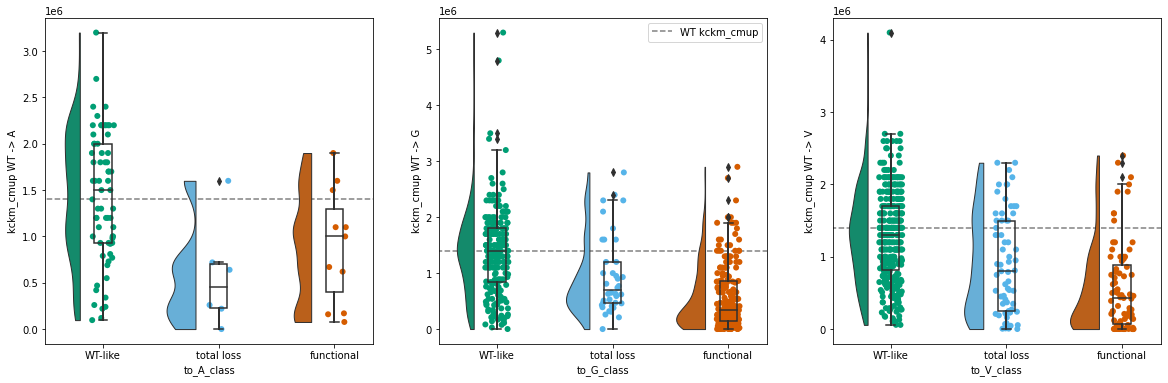

In [1099]:
#same thing with a single command: now x **must** be the categorical value
dx = "residue_class"; ort = "v"; pal = "Set2"; sigma = .3
fig, (ax0,ax1,ax2) = plt.subplots(1,3,figsize=(20,6))

pt.RainCloud(x = 'to_A_class', y = 'kckm_cmup_A', data = kckm_df, palette = ['#009e74','#56b4e9','#d55c00',"#5A5A5A"],
      bw = sigma,width_viol = 0.5, ax = ax0, orient = ort,point_size=6)
pt.RainCloud(x = 'to_G_class', y = 'kckm_cmup_G', data = kckm_df, palette = ['#009e74','#56b4e9','#d55c00',"#5A5A5A"],
      bw = sigma,width_viol = .5, ax = ax1, orient = ort,point_size=6)
pt.RainCloud(x = 'to_V_class', y = 'kckm_cmup_V', data = kckm_df, palette = ['#009e74','#56b4e9','#d55c00',"#5A5A5A"],
      bw = sigma,width_viol = .5, ax = ax2, orient = ort,point_size=6)
ax1.legend()

ax0.plot([-1,6],[1.4e6,1.4e6],c='gray',ls='--',zorder=-1,label='WT kckm_cmup')
ax1.plot([-1,6],[1.4e6,1.4e6],c='gray',ls='--',zorder=-1,label='WT kckm_cmup')
ax2.plot([-1,6],[1.4e6,1.4e6],c='gray',ls='--',zorder=-1,label='WT kckm_cmup')

ax0.set_xticklabels(['WT-like','total loss','functional'])
ax1.set_xticklabels(['WT-like','total loss','functional'])
ax2.set_xticklabels(['WT-like','total loss','functional'])

ax0.set_ylabel('kckm_cmup WT -> A')
ax1.set_ylabel('kckm_cmup WT -> G')
ax2.set_ylabel('kckm_cmup WT -> V')

ax1.legend()
plt.savefig('./figures/Q9KJX5_kckm_cmup_var_violin.pdf',tight_layout=True)

##### kckm mep

No handles with labels found to put in legend.


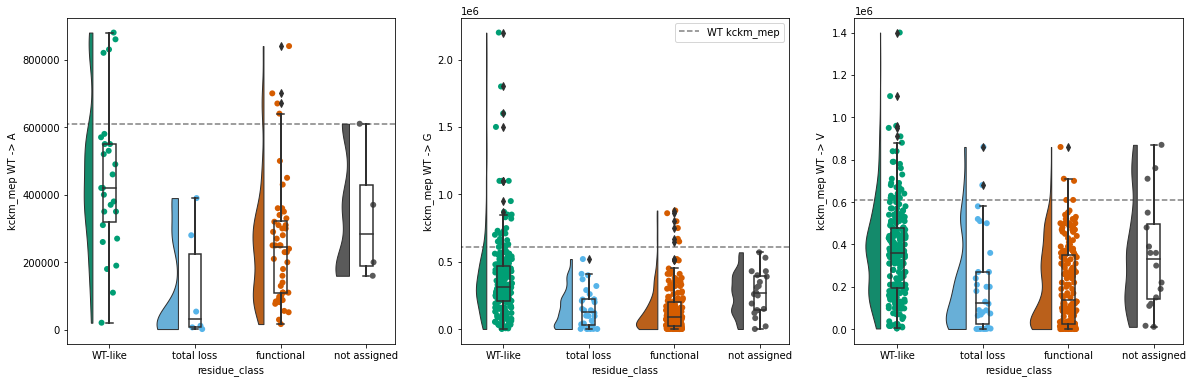

In [1024]:
#same thing with a single command: now x **must** be the categorical value
dx = "residue_class"; ort = "v"; pal = "Set2"; sigma = .3
fig, (ax0,ax1,ax2) = plt.subplots(1,3,figsize=(20,6))

pt.RainCloud(x = dx, y = 'kckm_mep_A', data = kckm_df, palette = ['#009e74','#56b4e9','#d55c00',"#5A5A5A"],
      bw = sigma,width_viol = 0.5, ax = ax0, orient = ort,point_size=6)
pt.RainCloud(x = dx, y = 'kckm_mep_G', data = kckm_df, palette = ['#009e74','#56b4e9','#d55c00',"#5A5A5A"],
      bw = sigma,width_viol = .5, ax = ax1, orient = ort,point_size=6)
pt.RainCloud(x = dx, y = 'kckm_mep_V', data = kckm_df, palette = ['#009e74','#56b4e9','#d55c00',"#5A5A5A"],
      bw = sigma,width_viol = .5, ax = ax2, orient = ort,point_size=6)
ax1.legend()

ax0.plot([-1,6],[6.1e5,6.1e5],c='gray',ls='--',zorder=-1,label='WT kckm_mep')
ax1.plot([-1,6],[6.1e5,6.1e5],c='gray',ls='--',zorder=-1,label='WT kckm_mep')
ax2.plot([-1,6],[6.1e5,6.1e5],c='gray',ls='--',zorder=-1,label='WT kckm_mep')

ax0.set_xticklabels(['WT-like','total loss','functional','not assigned'])
ax1.set_xticklabels(['WT-like','total loss','functional','not assigned'])
ax2.set_xticklabels(['WT-like','total loss','functional','not assigned'])

ax0.set_ylabel('kckm_mep WT -> A')
ax1.set_ylabel('kckm_mep WT -> G')
ax2.set_ylabel('kckm_mep WT -> V')

ax1.legend()
plt.savefig('./figures/Q9KJX5_kckm_mep_violin.pdf',tight_layout=True)

No handles with labels found to put in legend.


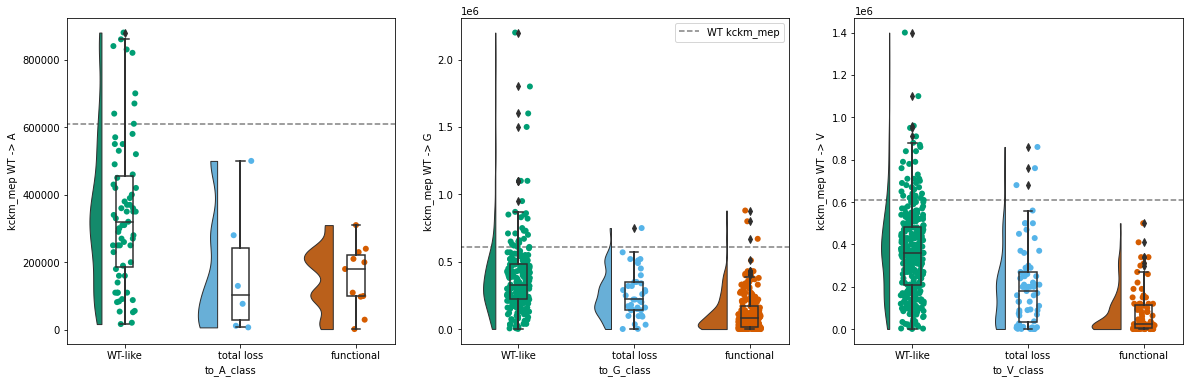

In [1025]:
#same thing with a single command: now x **must** be the categorical value
dx = "residue_class"; ort = "v"; pal = "Set2"; sigma = .3
fig, (ax0,ax1,ax2) = plt.subplots(1,3,figsize=(20,6))

pt.RainCloud(x = 'to_A_class', y = 'kckm_mep_A', data = kckm_df, palette = ['#009e74','#56b4e9','#d55c00',"#5A5A5A"],
      bw = sigma,width_viol = 0.5, ax = ax0, orient = ort,point_size=6)
pt.RainCloud(x = 'to_G_class', y = 'kckm_mep_G', data = kckm_df, palette = ['#009e74','#56b4e9','#d55c00',"#5A5A5A"],
      bw = sigma,width_viol = .5, ax = ax1, orient = ort,point_size=6)
pt.RainCloud(x = 'to_V_class', y = 'kckm_mep_V', data = kckm_df, palette = ['#009e74','#56b4e9','#d55c00',"#5A5A5A"],
      bw = sigma,width_viol = .5, ax = ax2, orient = ort,point_size=6)
ax1.legend()

ax0.plot([-1,6],[6.1e5,6.1e5],c='gray',ls='--',zorder=-1,label='WT kckm_mep')
ax1.plot([-1,6],[6.1e5,6.1e5],c='gray',ls='--',zorder=-1,label='WT kckm_mep')
ax2.plot([-1,6],[6.1e5,6.1e5],c='gray',ls='--',zorder=-1,label='WT kckm_mep')

ax0.set_xticklabels(['WT-like','total loss','functional'])
ax1.set_xticklabels(['WT-like','total loss','functional'])
ax2.set_xticklabels(['WT-like','total loss','functional'])

ax0.set_ylabel('kckm_mep WT -> A')
ax1.set_ylabel('kckm_mep WT -> G')
ax2.set_ylabel('kckm_mep WT -> V')

ax1.legend()
plt.savefig('./figures/Q9KJX5_kckm_mep_var_violin.pdf',tight_layout=True)

##### kckm cmup/mec

No handles with labels found to put in legend.


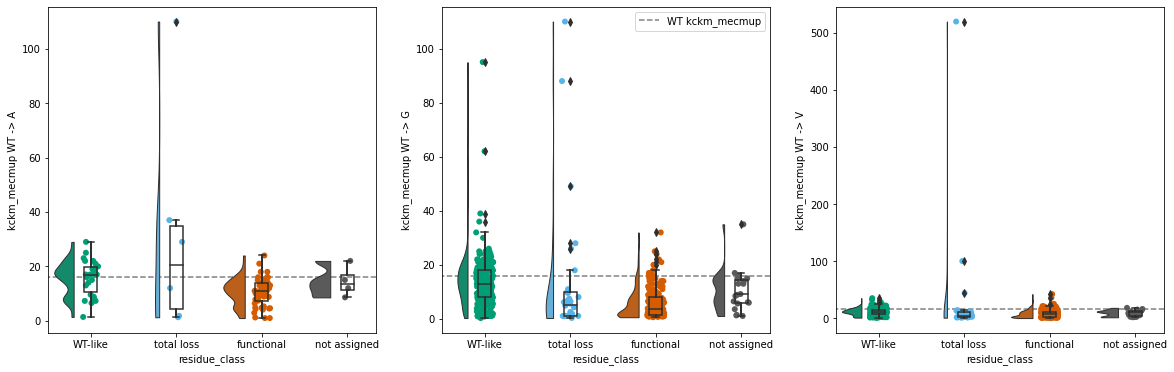

In [1026]:
#same thing with a single command: now x **must** be the categorical value
dx = "residue_class"; ort = "v"; pal = "Set2"; sigma = .3
fig, (ax0,ax1,ax2) = plt.subplots(1,3,figsize=(20,6))

pt.RainCloud(x = dx, y = 'kckm_mecmup_A', data = kckm_df, palette = ['#009e74','#56b4e9','#d55c00',"#5A5A5A"],
      bw = sigma,width_viol = 0.5, ax = ax0, orient = ort,point_size=6)
pt.RainCloud(x = dx, y = 'kckm_mecmup_G', data = kckm_df, palette = ['#009e74','#56b4e9','#d55c00',"#5A5A5A"],
      bw = sigma,width_viol = .5, ax = ax1, orient = ort,point_size=6)
pt.RainCloud(x = dx, y = 'kckm_mecmup_V', data = kckm_df, palette = ['#009e74','#56b4e9','#d55c00',"#5A5A5A"],
      bw = sigma,width_viol = .5, ax = ax2, orient = ort,point_size=6)
ax1.legend()

ax0.plot([-1,6],[1.6e1,1.6e1],c='gray',ls='--',zorder=-1,label='WT kckm_mecmup')
ax1.plot([-1,6],[1.6e1,1.6e1],c='gray',ls='--',zorder=-1,label='WT kckm_mecmup')
ax2.plot([-1,6],[1.6e1,1.6e1],c='gray',ls='--',zorder=-1,label='WT kckm_mecmup')

ax0.set_xticklabels(['WT-like','total loss','functional','not assigned'])
ax1.set_xticklabels(['WT-like','total loss','functional','not assigned'])
ax2.set_xticklabels(['WT-like','total loss','functional','not assigned'])

ax0.set_ylabel('kckm_mecmup WT -> A')
ax1.set_ylabel('kckm_mecmup WT -> G')
ax2.set_ylabel('kckm_mecmup WT -> V')

ax1.legend()
plt.savefig('./figures/Q9KJX5_kckm_mecmup_violin.pdf',tight_layout=True)

No handles with labels found to put in legend.


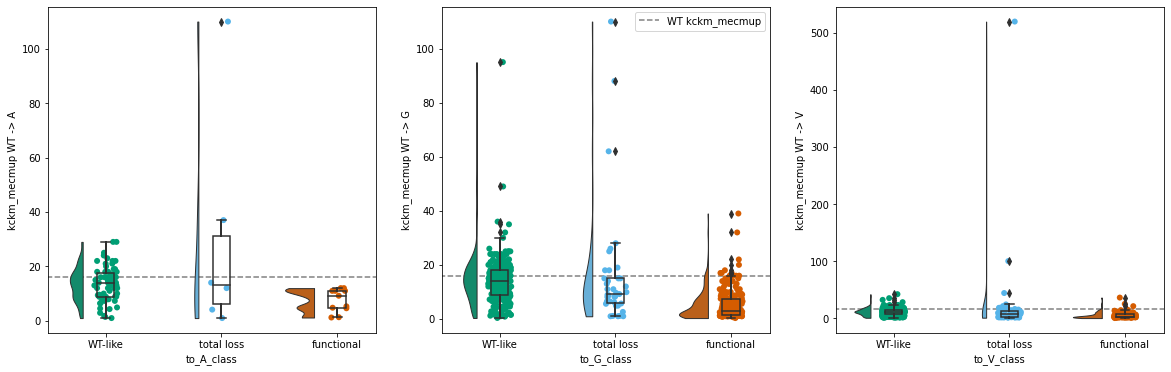

In [1027]:
#same thing with a single command: now x **must** be the categorical value
dx = "residue_class"; ort = "v"; pal = "Set2"; sigma = .3
fig, (ax0,ax1,ax2) = plt.subplots(1,3,figsize=(20,6))

pt.RainCloud(x = 'to_A_class', y = 'kckm_mecmup_A', data = kckm_df, palette = ['#009e74','#56b4e9','#d55c00',"#5A5A5A"],
      bw = sigma,width_viol = 0.5, ax = ax0, orient = ort,point_size=6)
pt.RainCloud(x = 'to_G_class', y = 'kckm_mecmup_G', data = kckm_df, palette = ['#009e74','#56b4e9','#d55c00',"#5A5A5A"],
      bw = sigma,width_viol = .5, ax = ax1, orient = ort,point_size=6)
pt.RainCloud(x = 'to_V_class', y = 'kckm_mecmup_V', data = kckm_df, palette = ['#009e74','#56b4e9','#d55c00',"#5A5A5A"],
      bw = sigma,width_viol = .5, ax = ax2, orient = ort,point_size=6)
ax1.legend()

ax0.plot([-1,6],[1.6e1,1.6e1],c='gray',ls='--',zorder=-1,label='WT kckm_mecmup')
ax1.plot([-1,6],[1.6e1,1.6e1],c='gray',ls='--',zorder=-1,label='WT kckm_mecmup')
ax2.plot([-1,6],[1.6e1,1.6e1],c='gray',ls='--',zorder=-1,label='WT kckm_mecmup')

ax0.set_xticklabels(['WT-like','total loss','functional'])
ax1.set_xticklabels(['WT-like','total loss','functional'])
ax2.set_xticklabels(['WT-like','total loss','functional'])

ax0.set_ylabel('kckm_mecmup WT -> A')
ax1.set_ylabel('kckm_mecmup WT -> G')
ax2.set_ylabel('kckm_mecmup WT -> V')

ax1.legend()
plt.savefig('./figures/Q9KJX5_kckm_mecmup_violin_var.pdf',tight_layout=True)

##### kcat/km G vs V

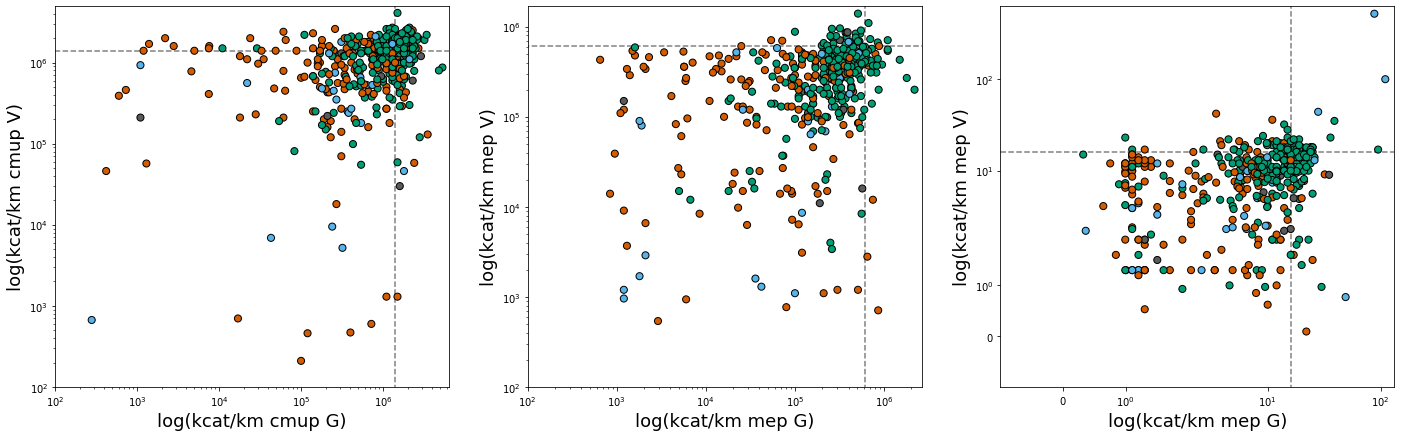

In [1039]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(24,7))

idx = np.isfinite(kckm_df['kckm_cmup_G'].to_numpy().flatten()) & np.isfinite(kckm_df['kckm_cmup_V'].to_numpy().flatten()) & np.isfinite(kckm_df['residue_class'].to_numpy().flatten())

pos=ax1.scatter(kckm_df['kckm_cmup_G'].to_numpy().flatten()[idx],kckm_df['kckm_cmup_V'].to_numpy()[idx],c=kckm_df['residue_class'].to_numpy().flatten()[idx],s=50,cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00","#5A5A5A","#5A5A5A","#5A5A5A"] ), edgecolor='k')

ax1.set_xlabel('log(kcat/km cmup G)',fontsize=18)
ax1.set_ylabel('log(kcat/km cmup V)',fontsize=18)

ax1.plot([-100000,1e7],[1.4e6,1.4e6],c='gray',ls='--',zorder=-1,label='WT kckm_cmup')
ax1.plot([1.4e6,1.4e6],[-100000,1e7],c='gray',ls='--',zorder=-1,label='WT kckm_cmup')

ax1.set_xlim(100,np.nanmax(kckm_df['kckm_cmup_G'].to_numpy())*1.2)
ax1.set_ylim(100,np.nanmax(kckm_df['kckm_cmup_V'].to_numpy())*1.2)

ax1.set_xscale('log')
ax1.set_yscale('log')


idx = np.isfinite(kckm_df['kckm_mep_G'].to_numpy().flatten()) & np.isfinite(kckm_df['kckm_mep_V'].to_numpy().flatten()) & np.isfinite(kckm_df['residue_class'].to_numpy().flatten())

pos=ax2.scatter(kckm_df['kckm_mep_G'].to_numpy().flatten()[idx],kckm_df['kckm_mep_V'].to_numpy()[idx],c=kckm_df['residue_class'].to_numpy().flatten()[idx],s=50,cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00","#5A5A5A","#5A5A5A","#5A5A5A"] ), edgecolor='k')

ax2.set_xlabel('log(kcat/km mep G)',fontsize=18)
ax2.set_ylabel('log(kcat/km mep V)',fontsize=18)

ax2.plot([-100000,1e7],[6.1e5,6.1e5],c='gray',ls='--',zorder=-1,label='WT kckm_mep')
ax2.plot([6.1e5,6.1e5],[-100000,1e7],c='gray',ls='--',zorder=-1,label='WT kckm_mep')

ax2.set_xlim(100,np.nanmax(kckm_df['kckm_mep_G'].to_numpy())*1.2)
ax2.set_ylim(100,np.nanmax(kckm_df['kckm_mep_V'].to_numpy())*1.2)

ax2.set_xscale('log')
ax2.set_yscale('log')

idx = np.isfinite(kckm_df['kckm_mecmup_G'].to_numpy().flatten()) & np.isfinite(kckm_df['kckm_mecmup_V'].to_numpy().flatten()) & np.isfinite(kckm_df['residue_class'].to_numpy().flatten())

pos=ax3.scatter(kckm_df['kckm_mecmup_G'].to_numpy().flatten()[idx],kckm_df['kckm_mecmup_V'].to_numpy()[idx],c=kckm_df['residue_class'].to_numpy().flatten()[idx],s=50,cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00","#5A5A5A","#5A5A5A","#5A5A5A"] ), edgecolor='k')

ax3.set_xlabel('log(kcat/km mep G)',fontsize=18)
ax3.set_ylabel('log(kcat/km mep V)',fontsize=18)

ax3.plot([-100,1e3],[1.6e1,1.6e1],c='gray',ls='--',zorder=-1,label='WT kckm_mep')
ax3.plot([1.6e1,1.6e1],[-100,1e3],c='gray',ls='--',zorder=-1,label='WT kckm_mep')

ax3.set_xlim(-1,np.nanmax(kckm_df['kckm_mecmup_G'].to_numpy())*1.2)
ax3.set_ylim(-1,np.nanmax(kckm_df['kckm_mecmup_V'].to_numpy())*1.2)

ax3.set_xscale('symlog')
ax3.set_yscale('symlog')



plt.savefig('./figures/kcat_km_mep_cmup_scatters.pdf')

In [ ]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(24,7))

idx = np.isfinite(kckm_df['kckm_cmup_G'].to_numpy().flatten()) & np.isfinite(kckm_df['kckm_cmup_V'].to_numpy().flatten()) & np.isfinite(kckm_df['to_G_class'].to_numpy().flatten())

pos=ax1.scatter(kckm_df['kckm_cmup_G'].to_numpy().flatten()[idx],kckm_df['kckm_cmup_V'].to_numpy()[idx],c=kckm_df['to_G_class'].to_numpy().flatten()[idx],s=kckm_df['TE_effects'].to_numpy().flatten()[idx],cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"] ), edgecolor='k')

ax1.set_xlabel('log(kcat/km cmup G)',fontsize=18)
ax1.set_ylabel('log(kcat/km cmup V)',fontsize=18)

ax1.plot([-100000,1e7],[1.4e6,1.4e6],c='gray',ls='--',zorder=-1,label='WT kckm_cmup')
ax1.plot([1.4e6,1.4e6],[-100000,1e7],c='gray',ls='--',zorder=-1,label='WT kckm_cmup')

ax1.set_xlim(100,np.nanmax(kckm_df['kckm_cmup_G'].to_numpy())*1.2)
ax1.set_ylim(100,np.nanmax(kckm_df['kckm_cmup_V'].to_numpy())*1.2)

ax1.set_xscale('log')
ax1.set_yscale('log')


idx = np.isfinite(kckm_df['kckm_mep_G'].to_numpy().flatten()) & np.isfinite(kckm_df['kckm_mep_V'].to_numpy().flatten()) & np.isfinite(kckm_df['to_G_class'].to_numpy().flatten())

pos=ax2.scatter(kckm_df['kckm_mep_G'].to_numpy().flatten()[idx],kckm_df['kckm_mep_V'].to_numpy()[idx],c=kckm_df['to_G_class'].to_numpy().flatten()[idx],s=kckm_df['TE_effects'].to_numpy().flatten()[idx],cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"] ), edgecolor='k')

ax2.set_xlabel('log(kcat/km mep G)',fontsize=18)
ax2.set_ylabel('log(kcat/km mep V)',fontsize=18)

ax2.plot([-100000,1e7],[6.1e5,6.1e5],c='gray',ls='--',zorder=-1,label='WT kckm_mep')
ax2.plot([6.1e5,6.1e5],[-100000,1e7],c='gray',ls='--',zorder=-1,label='WT kckm_mep')

ax2.set_xlim(100,np.nanmax(kckm_df['kckm_mep_G'].to_numpy())*1.2)
ax2.set_ylim(100,np.nanmax(kckm_df['kckm_mep_V'].to_numpy())*1.2)

ax2.set_xscale('log')
ax2.set_yscale('log')

idx = np.isfinite(kckm_df['kckm_mecmup_G'].to_numpy().flatten()) & np.isfinite(kckm_df['kckm_mecmup_V'].to_numpy().flatten()) & np.isfinite(kckm_df['to_G_class'].to_numpy().flatten())

pos=ax3.scatter(kckm_df['kckm_mecmup_G'].to_numpy().flatten()[idx],kckm_df['kckm_mecmup_V'].to_numpy()[idx],c=kckm_df['to_G_class'].to_numpy().flatten()[idx],s=kckm_df['TE_effects'].to_numpy().flatten()[idx],cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"] ), edgecolor='k')

ax3.set_xlabel('log(kcat/km mep G)',fontsize=18)
ax3.set_ylabel('log(kcat/km mep V)',fontsize=18)

ax3.plot([-100,1e3],[1.6e1,1.6e1],c='gray',ls='--',zorder=-1,label='WT kckm_mep')
ax3.plot([1.6e1,1.6e1],[-100,1e3],c='gray',ls='--',zorder=-1,label='WT kckm_mep')

ax3.set_xlim(-1,np.nanmax(kckm_df['kckm_mecmup_G'].to_numpy())*1.2)
ax3.set_ylim(-1,np.nanmax(kckm_df['kckm_mecmup_V'].to_numpy())*1.2)

ax3.set_xscale('symlog')
ax3.set_yscale('symlog')


plt.savefig('./figures/kcat_km_mep_cmup_to_G_scatters.pdf')

In [ ]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(24,7))

idx = np.isfinite(kckm_df['kckm_cmup_G'].to_numpy().flatten()) & np.isfinite(kckm_df['kckm_cmup_V'].to_numpy().flatten()) & np.isfinite(kckm_df['to_V_class'].to_numpy().flatten())

pos=ax1.scatter(kckm_df['kckm_cmup_G'].to_numpy().flatten()[idx],kckm_df['kckm_cmup_V'].to_numpy()[idx],c=kckm_df['to_V_class'].to_numpy().flatten()[idx],s=50,cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"] ), edgecolor='k')

ax1.set_xlabel('log(kcat/km cmup G)',fontsize=18)
ax1.set_ylabel('log(kcat/km cmup V)',fontsize=18)

ax1.plot([-100000,1e7],[1.4e6,1.4e6],c='gray',ls='--',zorder=-1,label='WT kckm_cmup')
ax1.plot([1.4e6,1.4e6],[-100000,1e7],c='gray',ls='--',zorder=-1,label='WT kckm_cmup')

ax1.set_xlim(100,np.nanmax(kckm_df['kckm_cmup_G'].to_numpy())*1.2)
ax1.set_ylim(100,np.nanmax(kckm_df['kckm_cmup_V'].to_numpy())*1.2)

ax1.set_xscale('log')
ax1.set_yscale('log')


idx = np.isfinite(kckm_df['kckm_mep_G'].to_numpy().flatten()) & np.isfinite(kckm_df['kckm_mep_V'].to_numpy().flatten()) & np.isfinite(kckm_df['to_V_class'].to_numpy().flatten())

pos=ax2.scatter(kckm_df['kckm_mep_G'].to_numpy().flatten()[idx],kckm_df['kckm_mep_V'].to_numpy()[idx],c=kckm_df['to_V_class'].to_numpy().flatten()[idx],s=50,cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"] ), edgecolor='k')

ax2.set_xlabel('log(kcat/km mep G)',fontsize=18)
ax2.set_ylabel('log(kcat/km mep V)',fontsize=18)

ax2.plot([-100000,1e7],[6.1e5,6.1e5],c='gray',ls='--',zorder=-1,label='WT kckm_mep')
ax2.plot([6.1e5,6.1e5],[-100000,1e7],c='gray',ls='--',zorder=-1,label='WT kckm_mep')

ax2.set_xlim(100,np.nanmax(kckm_df['kckm_mep_G'].to_numpy())*1.2)
ax2.set_ylim(100,np.nanmax(kckm_df['kckm_mep_V'].to_numpy())*1.2)

ax2.set_xscale('log')
ax2.set_yscale('log')

idx = np.isfinite(kckm_df['kckm_mecmup_G'].to_numpy().flatten()) & np.isfinite(kckm_df['kckm_mecmup_V'].to_numpy().flatten()) & np.isfinite(kckm_df['to_V_class'].to_numpy().flatten())

pos=ax3.scatter(kckm_df['kckm_mecmup_G'].to_numpy().flatten()[idx],kckm_df['kckm_mecmup_V'].to_numpy()[idx],c=kckm_df['to_V_class'].to_numpy().flatten()[idx],s=50,cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"] ), edgecolor='k',label='variant')

ax3.set_xlabel('log(kcat/km mep G)',fontsize=18)
ax3.set_ylabel('log(kcat/km mep V)',fontsize=18)

ax3.plot([-100,1e3],[1.6e1,1.6e1],c='gray',ls='--',zorder=-1,label='WT kckm_mep')
ax3.plot([1.6e1,1.6e1],[-100,1e3],c='gray',ls='--',zorder=-1,label='WT kckm_mep')

ax3.set_xlim(-1,np.nanmax(kckm_df['kckm_mecmup_G'].to_numpy())*1.2)
ax3.set_ylim(-1,np.nanmax(kckm_df['kckm_mecmup_V'].to_numpy())*1.2)

ax3.set_xscale('symlog')
ax3.set_yscale('symlog')


ax3.legend()
plt.savefig('./figures/kcat_km_mep_cmup_to_V_scatters.pdf')

#### ratio/avg kcatkm

In [1042]:
kckm_obs_df=pd.DataFrame({'position':Q9KJX5_residues,'residue_class':Q9KJX5_3mode_prediction.flatten(),'to_A_class':Q9KJX5_variant_pred[:,0],'to_G_class':Q9KJX5_variant_pred[:,5],'to_V_class':Q9KJX5_variant_pred[:,17],
                    'kckm_cmup_ratio':kcMUP_scores[:,17]/kcMUP_scores[:,5],'kckm_cmup_avg':(kcMUP_scores[:,5]+kcMUP_scores[:,17])/2,
                    'kckm_mep_ratio':kMeP_scores[:,17]/kMeP_scores[:,5],'kckm_mep_avg':(kMeP_scores[:,5]+kMeP_scores[:,17])/2,
                    'kckm_mecmup_ratio':kmecMUP_scores[:,17]/kmecMUP_scores[:,5],'kckm_mecmup_avg':(kmecMUP_scores[:,5]+kmecMUP_scores[:,17])/2,
                    'TE_effects':Q9KJX5_TE})

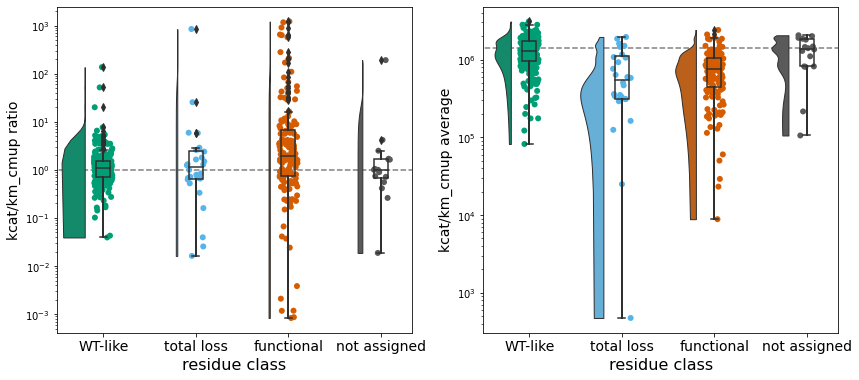

In [1043]:
#same thing with a single command: now x **must** be the categorical value
dx = "residue_class"; ort = "v"; pal = "Set2"; sigma = .3
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(14,6))

pt.RainCloud(x = 'residue_class', y = 'kckm_cmup_ratio', data = kckm_obs_df, palette = ['#009e74','#56b4e9','#d55c00',"#5A5A5A"],
      bw = sigma,width_viol = .5, ax = ax0, orient = ort,point_size=6)
pt.RainCloud(x = 'residue_class', y = 'kckm_cmup_avg', data = kckm_obs_df, palette = ['#009e74','#56b4e9','#d55c00',"#5A5A5A"],
      bw = sigma,width_viol = .5, ax = ax1, orient = ort,point_size=6)

#ax0.plot([-1,6],[1.6e1,1.6e1],c='gray',ls='--',zorder=-1,label='WT kckm_mecmup')
#ax1.plot([-1,6],[1.6e1,1.6e1],c='gray',ls='--',zorder=-1,label='WT kckm_mecmup')

ax0.set_xticklabels(['WT-like','total loss','functional','not assigned'],fontsize=14)
ax1.set_xticklabels(['WT-like','total loss','functional','not assigned'],fontsize=14)

ax0.set_ylabel('kcat/km_cmup ratio',fontsize=14)
ax1.set_ylabel('kcat/km_cmup average',fontsize=14)

ax0.set_xlabel('residue class',fontsize=16)
ax1.set_xlabel('residue class',fontsize=16)


ax0.set_yscale('log')
ax1.set_yscale('log')

ax0.plot([-1,5],[1,1],c='gray',ls='--',zorder=-1,label='WT kckm_cmup')
ax1.plot([-1,5],[1.4e6,1.4e6],c='gray',ls='--',zorder=-1,label='WT kckm_cmup')

plt.savefig('./figures/Q9KJX5_kckm_cmup_violin_ratio_avg.pdf',tight_layout=True)

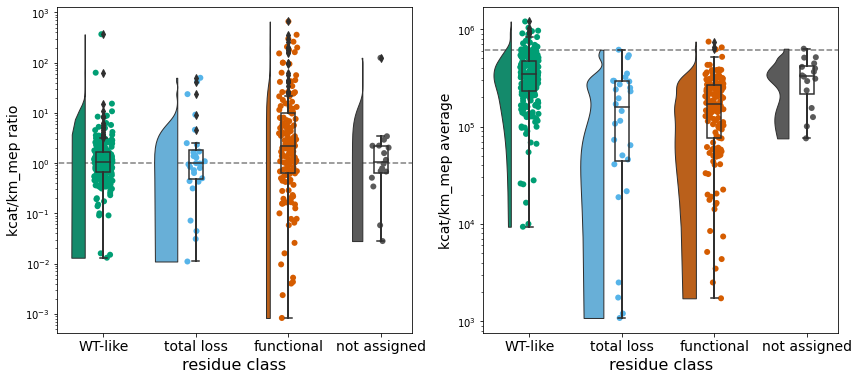

In [1044]:
#same thing with a single command: now x **must** be the categorical value
dx = "residue_class"; ort = "v"; pal = "Set2"; sigma = .3
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(14,6))

pt.RainCloud(x = 'residue_class', y = 'kckm_mep_ratio', data = kckm_obs_df, palette = ['#009e74','#56b4e9','#d55c00',"#5A5A5A"],
      bw = sigma,width_viol = .5, ax = ax0, orient = ort,point_size=6)
pt.RainCloud(x = 'residue_class', y = 'kckm_mep_avg', data = kckm_obs_df, palette = ['#009e74','#56b4e9','#d55c00',"#5A5A5A"],
      bw = sigma,width_viol = .5, ax = ax1, orient = ort,point_size=6)

#ax0.plot([-1,6],[1.6e1,1.6e1],c='gray',ls='--',zorder=-1,label='WT kckm_mecmup')
#ax1.plot([-1,6],[1.6e1,1.6e1],c='gray',ls='--',zorder=-1,label='WT kckm_mecmup')

ax0.set_xticklabels(['WT-like','total loss','functional','not assigned'],fontsize=14)
ax1.set_xticklabels(['WT-like','total loss','functional','not assigned'],fontsize=14)

ax0.set_ylabel('kcat/km_mep ratio',fontsize=14)
ax1.set_ylabel('kcat/km_mep average',fontsize=14)

ax0.set_xlabel('residue class',fontsize=16)
ax1.set_xlabel('residue class',fontsize=16)

ax0.set_yscale('log')
ax1.set_yscale('log')
ax0.plot([-1,5],[1,1],c='gray',ls='--',zorder=-1,label='WT kckm_mep')
ax1.plot([-1,5],[6.1e5,6.1e5],c='gray',ls='--',zorder=-1,label='WT kckm_mep')

plt.savefig('./figures/Q9KJX5_kckm_mep_violin_ratio_avg.pdf',tight_layout=True)

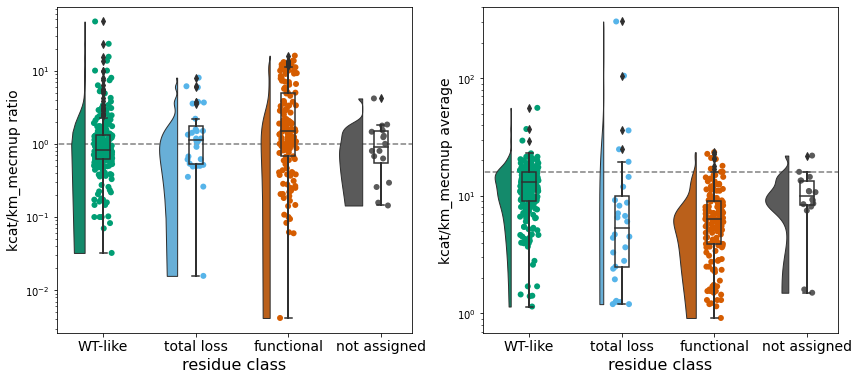

In [1045]:
#same thing with a single command: now x **must** be the categorical value
dx = "residue_class"; ort = "v"; pal = "Set2"; sigma = .3
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(14,6))

pt.RainCloud(x = 'residue_class', y = 'kckm_mecmup_ratio', data = kckm_obs_df, palette = ['#009e74','#56b4e9','#d55c00',"#5A5A5A"],
      bw = sigma,width_viol = .5, ax = ax0, orient = ort,point_size=6)
pt.RainCloud(x = 'residue_class', y = 'kckm_mecmup_avg', data = kckm_obs_df, palette = ['#009e74','#56b4e9','#d55c00',"#5A5A5A"],
      bw = sigma,width_viol = .5, ax = ax1, orient = ort,point_size=6)

#ax0.plot([-1,6],[1.6e1,1.6e1],c='gray',ls='--',zorder=-1,label='WT kckm_mecmup')
#ax1.plot([-1,6],[1.6e1,1.6e1],c='gray',ls='--',zorder=-1,label='WT kckm_mecmup')

ax0.set_xticklabels(['WT-like','total loss','functional','not assigned'],fontsize=14)
ax1.set_xticklabels(['WT-like','total loss','functional','not assigned'],fontsize=14)

ax0.set_ylabel('kcat/km_mecmup ratio',fontsize=14)
ax1.set_ylabel('kcat/km_mecmup average',fontsize=14)

ax0.set_xlabel('residue class',fontsize=16)
ax1.set_xlabel('residue class',fontsize=16)

ax0.set_yscale('log')
ax1.set_yscale('log')
ax0.plot([-1,5],[1,1],c='gray',ls='--',zorder=-1,label='WT kckm_mecmup')
ax1.plot([-1,5],[1.6e1,1.6e1],c='gray',ls='--',zorder=-1,label='WT kckm_mecmup')

plt.savefig('./figures/Q9KJX5_kckm_mecmup_violin_ratio_avg.pdf',tight_layout=True)

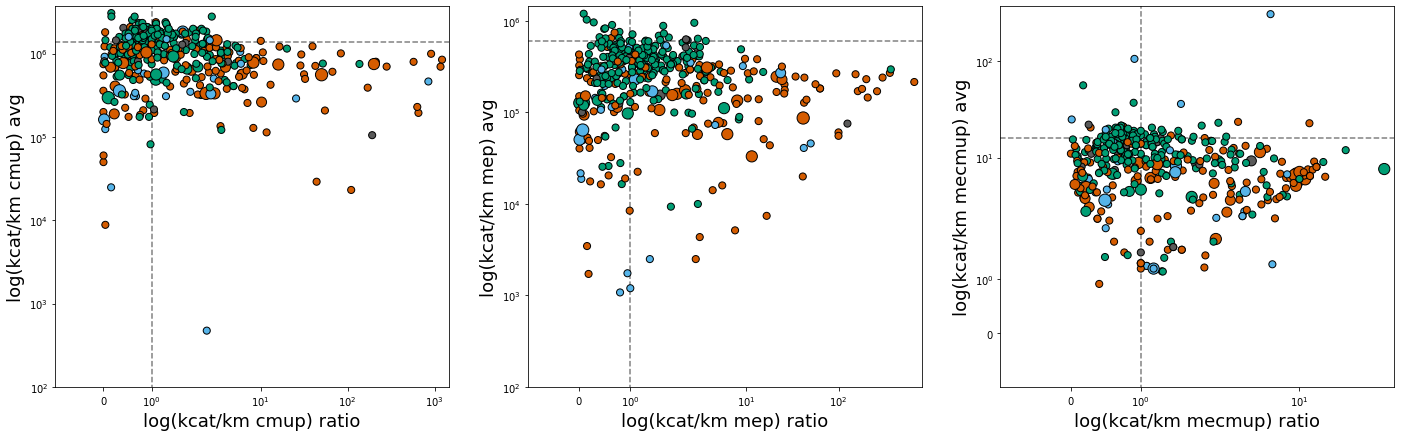

In [1046]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(24,7))

idx = np.isfinite(kckm_obs_df['kckm_cmup_ratio'].to_numpy().flatten()) & np.isfinite(kckm_obs_df['kckm_cmup_avg'].to_numpy().flatten()) & np.isfinite(kckm_obs_df['residue_class'].to_numpy().flatten())

pos=ax1.scatter(kckm_obs_df['kckm_cmup_ratio'].to_numpy().flatten()[idx],kckm_obs_df['kckm_cmup_avg'].to_numpy()[idx],c=kckm_obs_df['residue_class'].to_numpy().flatten()[idx],s=kckm_obs_df['TE_effects'].to_numpy().flatten()[idx],cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00","#5A5A5A","#5A5A5A","#5A5A5A"] ), edgecolor='k')

ax1.set_xlabel('log(kcat/km cmup) ratio',fontsize=18)
ax1.set_ylabel('log(kcat/km cmup) avg',fontsize=18)

ax1.plot([-100000,1e7],[1.4e6,1.4e6],c='gray',ls='--',zorder=-1,label='WT kckm_cmup')
ax1.plot([1,1],[-100000,1e7],c='gray',ls='--',zorder=-1,label='WT kckm_cmup')

ax1.set_xlim(-1,np.nanmax(kckm_obs_df['kckm_cmup_ratio'].to_numpy())*1.2)
ax1.set_ylim(100,np.nanmax(kckm_obs_df['kckm_cmup_avg'].to_numpy())*1.2)

ax1.set_xscale('symlog')
ax1.set_yscale('symlog')


idx = np.isfinite(kckm_obs_df['kckm_mep_ratio'].to_numpy().flatten()) & np.isfinite(kckm_obs_df['kckm_mep_avg'].to_numpy().flatten()) & np.isfinite(kckm_obs_df['residue_class'].to_numpy().flatten())

pos=ax2.scatter(kckm_obs_df['kckm_mep_ratio'].to_numpy().flatten()[idx],kckm_obs_df['kckm_mep_avg'].to_numpy()[idx],c=kckm_obs_df['residue_class'].to_numpy().flatten()[idx],s=kckm_obs_df['TE_effects'].to_numpy().flatten()[idx],cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00","#5A5A5A","#5A5A5A","#5A5A5A"] ), edgecolor='k')

ax2.set_xlabel('log(kcat/km mep) ratio',fontsize=18)
ax2.set_ylabel('log(kcat/km mep) avg',fontsize=18)

ax2.plot([-100000,1e7],[6.1e5,6.1e5],c='gray',ls='--',zorder=-1,label='WT kckm_mep')
ax2.plot([1,1],[-100000,1e7],c='gray',ls='--',zorder=-1,label='WT kckm_mep')

ax2.set_xlim(-1,np.nanmax(kckm_obs_df['kckm_mep_ratio'].to_numpy())*1.2)
ax2.set_ylim(100,np.nanmax(kckm_obs_df['kckm_mep_avg'].to_numpy())*1.2)

ax2.set_xscale('symlog')
ax2.set_yscale('symlog')

idx = np.isfinite(kckm_obs_df['kckm_mecmup_ratio'].to_numpy().flatten()) & np.isfinite(kckm_obs_df['kckm_mecmup_avg'].to_numpy().flatten()) & np.isfinite(kckm_obs_df['residue_class'].to_numpy().flatten())

pos=ax3.scatter(kckm_obs_df['kckm_mecmup_ratio'].to_numpy().flatten()[idx],kckm_obs_df['kckm_mecmup_avg'].to_numpy()[idx],c=kckm_obs_df['residue_class'].to_numpy().flatten()[idx],s=kckm_obs_df['TE_effects'].to_numpy().flatten()[idx],cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00","#5A5A5A","#5A5A5A","#5A5A5A"] ), edgecolor='k')

ax3.set_xlabel('log(kcat/km mecmup) ratio',fontsize=18)
ax3.set_ylabel('log(kcat/km mecmup) avg',fontsize=18)

ax3.plot([-1,1e3],[1.6e1,1.6e1],c='gray',ls='--',zorder=-1,label='WT kckm_mecmup')
ax3.plot([1,1],[-100,1e3],c='gray',ls='--',zorder=-1,label='WT kckm_mecmup')

ax3.set_xlim(-1,np.nanmax(kckm_obs_df['kckm_mecmup_ratio'].to_numpy())*1.2)
ax3.set_ylim(-1,np.nanmax(kckm_obs_df['kckm_mecmup_avg'].to_numpy())*1.2)

ax3.set_xscale('symlog')
ax3.set_yscale('symlog')



plt.savefig('./figures/kcat_km_avg_ratio_scatters.pdf')

#### map with TE effect on k cmup

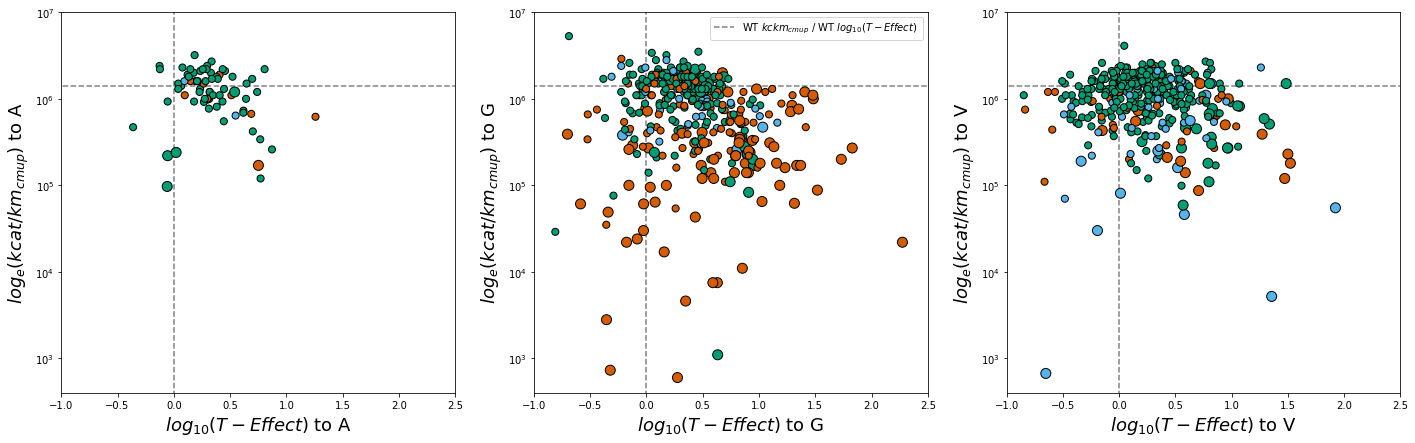

In [1047]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(24,7))

idx = np.isfinite(kckm_df['TE_effects_A'].to_numpy().flatten()) & np.isfinite(kckm_df['kckm_cmup_A'].to_numpy().flatten()) & np.isfinite(kckm_df['to_A_class'].to_numpy().flatten())
pos=ax1.scatter(kckm_df['TE_effects_A'].to_numpy().flatten()[idx],kckm_df['kckm_cmup_A'].to_numpy()[idx],c=kckm_df['to_A_class'].to_numpy().flatten()[idx],s=kckm_df['TE_quality_37_A'].to_numpy()[idx],cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"] ), edgecolor='k')

ax1.set_xlabel('$log_{10}(T-Effect)$ to A',fontsize=18)
ax1.set_ylabel('$log_{e}(kcat/km_{cmup})$ to A',fontsize=18)

ax1.plot([-100000,1e7],[1.4e6,1.4e6],c='gray',ls='--',zorder=-1,label='WT $kckm_{cmup}$ / WT $log_{10}(T-Effect)$ ')
ax1.plot([0,0],[0,1e8],c='gray',ls='--',zorder=-1)

ax1.set_xlim(-1,2.5)
ax1.set_ylim(400,1e7)

#ax1.set_xscale('symlog')
ax1.set_yscale('symlog')


idx = np.isfinite(kckm_df['TE_effects_G'].to_numpy().flatten()) & np.isfinite(kckm_df['kckm_cmup_G'].to_numpy().flatten()) & np.isfinite(kckm_df['to_G_class'].to_numpy().flatten())
pos=ax2.scatter(kckm_df['TE_effects_G'].to_numpy().flatten()[idx],kckm_df['kckm_cmup_G'].to_numpy()[idx],c=kckm_df['to_G_class'].to_numpy().flatten()[idx],s=kckm_df['TE_quality_37_G'].to_numpy()[idx],cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"] ), edgecolor='k')

ax2.set_xlabel('$log_{10}(T-Effect)$ to G',fontsize=18)
ax2.set_ylabel('$log_{e}(kcat/km_{cmup})$ to G',fontsize=18)

ax2.plot([-100000,1e7],[1.4e6,1.4e6],c='gray',ls='--',zorder=-1,label='WT $kckm_{cmup}$ / WT $log_{10}(T-Effect)$ ')
ax2.plot([0,0],[0,1e8],c='gray',ls='--',zorder=-1)

ax2.set_xlim(-1,2.5)
ax2.set_ylim(400,1e7)

#ax2.set_xscale('symlog')
ax2.set_yscale('symlog')


idx = np.isfinite(kckm_df['TE_effects_V'].to_numpy().flatten()) & np.isfinite(kckm_df['kckm_cmup_V'].to_numpy().flatten()) & np.isfinite(kckm_df['to_V_class'].to_numpy().flatten())
#print(kckm_df['TE_quality_37_V'].to_numpy()[idx])
pos=ax3.scatter(kckm_df['TE_effects_V'].to_numpy().flatten()[idx],kckm_df['kckm_cmup_V'].to_numpy()[idx],c=kckm_df['to_V_class'].to_numpy().flatten()[idx],s=kckm_df['TE_quality_37_V'].to_numpy()[idx],cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"] ), edgecolor='k')

ax3.set_xlabel('$log_{10}(T-Effect)$ to V',fontsize=18)
ax3.set_ylabel('$log_{e}(kcat/km_{cmup})$ to V',fontsize=18)

ax3.plot([-100000,1e7],[1.4e6,1.4e6],c='gray',ls='--',zorder=-1,label='WT $kckm_{cmup}$ / WT $log_{10}(T-Effect)$ ')
ax3.plot([0,0],[0,1e8],c='gray',ls='--',zorder=-1)

ax3.set_xlim(-1,2.5)
ax3.set_ylim(400,1e7)

#ax2.set_xscale('symlog')
ax3.set_yscale('symlog')

ax2.legend()

plt.savefig('./figures/kcat_km_cmup_TEffect_scatters_size_limit.pdf')

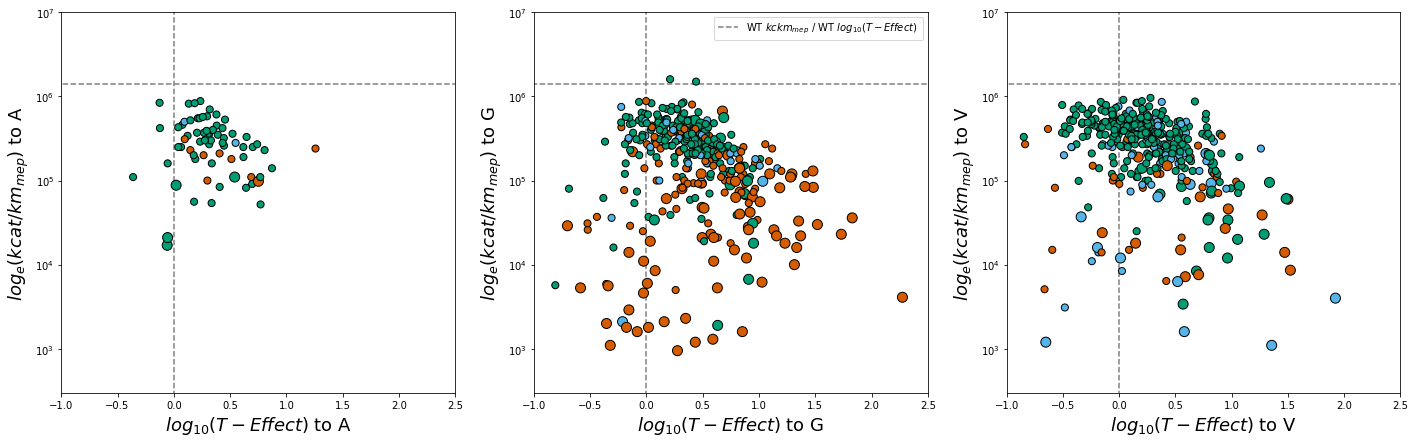

In [1048]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(24,7))

idx = np.isfinite(kckm_df['TE_effects_A'].to_numpy().flatten()) & np.isfinite(kckm_df['kckm_mep_A'].to_numpy().flatten()) & np.isfinite(kckm_df['to_A_class'].to_numpy().flatten())
pos=ax1.scatter(kckm_df['TE_effects_A'].to_numpy().flatten()[idx],kckm_df['kckm_mep_A'].to_numpy()[idx],c=kckm_df['to_A_class'].to_numpy().flatten()[idx],s=kckm_df['TE_quality_37_A'].to_numpy()[idx],cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"] ), edgecolor='k')

ax1.set_xlabel('$log_{10}(T-Effect)$ to A',fontsize=18)
ax1.set_ylabel('$log_{e}(kcat/km_{mep})$ to A',fontsize=18)

ax1.plot([-100000,1e7],[1.4e6,1.4e6],c='gray',ls='--',zorder=-1,label='WT $kckm_{mep}$ / WT $log_{10}(T-Effect)$ ')
ax1.plot([0,0],[0,1e8],c='gray',ls='--',zorder=-1)

ax1.set_xlim(-1,2.5)
ax1.set_ylim(300,1e7)

#ax1.set_xscale('symlog')
ax1.set_yscale('symlog')


idx = np.isfinite(kckm_df['TE_effects_G'].to_numpy().flatten()) & np.isfinite(kckm_df['kckm_mep_G'].to_numpy().flatten()) & np.isfinite(kckm_df['to_G_class'].to_numpy().flatten())
pos=ax2.scatter(kckm_df['TE_effects_G'].to_numpy().flatten()[idx],kckm_df['kckm_mep_G'].to_numpy()[idx],c=kckm_df['to_G_class'].to_numpy().flatten()[idx],s=kckm_df['TE_quality_37_G'].to_numpy()[idx],cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"] ), edgecolor='k')

ax2.set_xlabel('$log_{10}(T-Effect)$ to G',fontsize=18)
ax2.set_ylabel('$log_{e}(kcat/km_{mep})$ to G',fontsize=18)

ax2.plot([-100000,1e7],[1.4e6,1.4e6],c='gray',ls='--',zorder=-1,label='WT $kckm_{mep}$ / WT $log_{10}(T-Effect)$ ')
ax2.plot([0,0],[0,1e8],c='gray',ls='--',zorder=-1)

ax2.set_xlim(-1,2.5)
ax2.set_ylim(300,1e7)

#ax2.set_xscale('symlog')
ax2.set_yscale('symlog')


idx = np.isfinite(kckm_df['TE_effects_V'].to_numpy().flatten()) & np.isfinite(kckm_df['kckm_mep_V'].to_numpy().flatten()) & np.isfinite(kckm_df['to_V_class'].to_numpy().flatten())
#print(kckm_df['TE_quality_37_V'].to_numpy()[idx])
pos=ax3.scatter(kckm_df['TE_effects_V'].to_numpy().flatten()[idx],kckm_df['kckm_mep_V'].to_numpy()[idx],c=kckm_df['to_V_class'].to_numpy().flatten()[idx],s=kckm_df['TE_quality_37_V'].to_numpy()[idx],cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"] ), edgecolor='k')

ax3.set_xlabel('$log_{10}(T-Effect)$ to V',fontsize=18)
ax3.set_ylabel('$log_{e}(kcat/km_{mep})$ to V',fontsize=18)

ax3.plot([-100000,1e7],[1.4e6,1.4e6],c='gray',ls='--',zorder=-1,label='WT $kckm_{mep}$ / WT $log_{10}(T-Effect)$ ')
ax3.plot([0,0],[0,1e8],c='gray',ls='--',zorder=-1)

ax3.set_xlim(-1,2.5)
ax3.set_ylim(300,1e7)

#ax2.set_xscale('symlog')
ax3.set_yscale('symlog')

ax2.legend()

plt.savefig('./figures/kcat_km_mep_TEffect_scatters_size_limit.pdf')

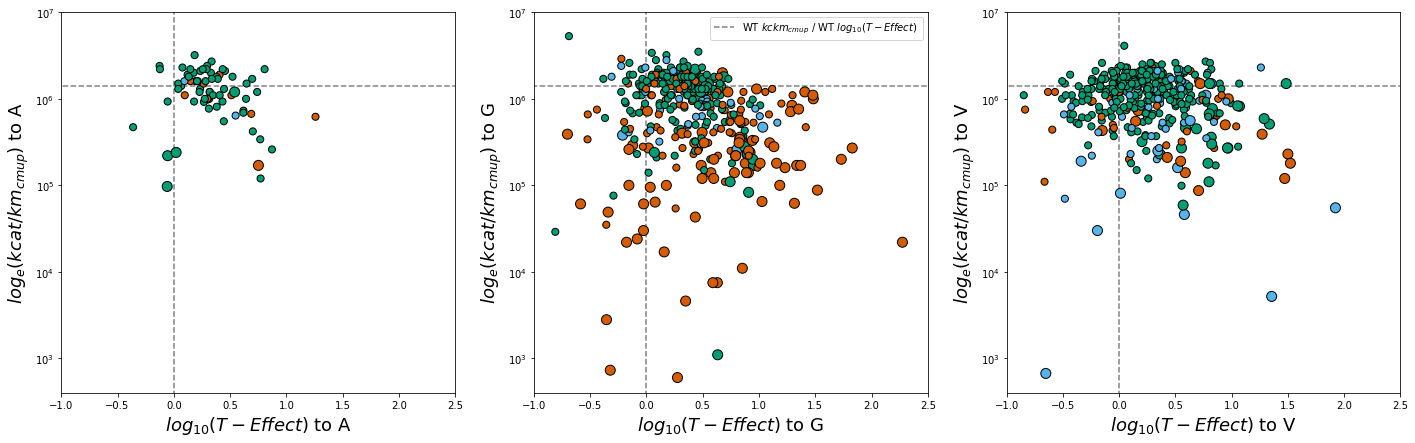

In [1049]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(24,7))

idx = np.isfinite(kckm_df['TE_effects_A'].to_numpy().flatten()) & np.isfinite(kckm_df['kckm_cmup_A'].to_numpy().flatten()) & np.isfinite(kckm_df['to_A_class'].to_numpy().flatten())
pos=ax1.scatter(kckm_df['TE_effects_A'].to_numpy().flatten()[idx],kckm_df['kckm_cmup_A'].to_numpy()[idx],c=kckm_df['to_A_class'].to_numpy().flatten()[idx],s=kckm_df['TE_quality_37_A'].to_numpy()[idx],cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"] ), edgecolor='k')

ax1.set_xlabel('$log_{10}(T-Effect)$ to A',fontsize=18)
ax1.set_ylabel('$log_{e}(kcat/km_{cmup})$ to A',fontsize=18)

ax1.plot([-100000,1e7],[1.4e6,1.4e6],c='gray',ls='--',zorder=-1,label='WT $kckm_{cmup}$ / WT $log_{10}(T-Effect)$ ')
ax1.plot([0,0],[0,1e8],c='gray',ls='--',zorder=-1)

ax1.set_xlim(-1,2.5)
ax1.set_ylim(400,1e7)

#ax1.set_xscale('symlog')
ax1.set_yscale('symlog')


idx = np.isfinite(kckm_df['TE_effects_G'].to_numpy().flatten()) & np.isfinite(kckm_df['kckm_cmup_G'].to_numpy().flatten()) & np.isfinite(kckm_df['to_G_class'].to_numpy().flatten())
pos=ax2.scatter(kckm_df['TE_effects_G'].to_numpy().flatten()[idx],kckm_df['kckm_cmup_G'].to_numpy()[idx],c=kckm_df['to_G_class'].to_numpy().flatten()[idx],s=kckm_df['TE_quality_37_G'].to_numpy()[idx],cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"] ), edgecolor='k')

ax2.set_xlabel('$log_{10}(T-Effect)$ to G',fontsize=18)
ax2.set_ylabel('$log_{e}(kcat/km_{cmup})$ to G',fontsize=18)

ax2.plot([-100000,1e7],[1.4e6,1.4e6],c='gray',ls='--',zorder=-1,label='WT $kckm_{cmup}$ / WT $log_{10}(T-Effect)$ ')
ax2.plot([0,0],[0,1e8],c='gray',ls='--',zorder=-1)

ax2.set_xlim(-1,2.5)
ax2.set_ylim(400,1e7)

#ax2.set_xscale('symlog')
ax2.set_yscale('symlog')


idx = np.isfinite(kckm_df['TE_effects_V'].to_numpy().flatten()) & np.isfinite(kckm_df['kckm_cmup_V'].to_numpy().flatten()) & np.isfinite(kckm_df['to_V_class'].to_numpy().flatten())
#print(kckm_df['TE_quality_37_V'].to_numpy()[idx])
pos=ax3.scatter(kckm_df['TE_effects_V'].to_numpy().flatten()[idx],kckm_df['kckm_cmup_V'].to_numpy()[idx],c=kckm_df['to_V_class'].to_numpy().flatten()[idx],s=kckm_df['TE_quality_37_V'].to_numpy()[idx],cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"] ), edgecolor='k')

ax3.set_xlabel('$log_{10}(T-Effect)$ to V',fontsize=18)
ax3.set_ylabel('$log_{e}(kcat/km_{cmup})$ to V',fontsize=18)

ax3.plot([-100000,1e7],[1.4e6,1.4e6],c='gray',ls='--',zorder=-1,label='WT $kckm_{cmup}$ / WT $log_{10}(T-Effect)$ ')
ax3.plot([0,0],[0,1e8],c='gray',ls='--',zorder=-1)

ax3.set_xlim(-1,2.5)
ax3.set_ylim(400,1e7)

#ax2.set_xscale('symlog')
ax3.set_yscale('symlog')

ax2.legend()

plt.savefig('./figures/kcat_km_cmup_TEffect_scatters_size_limit.pdf')

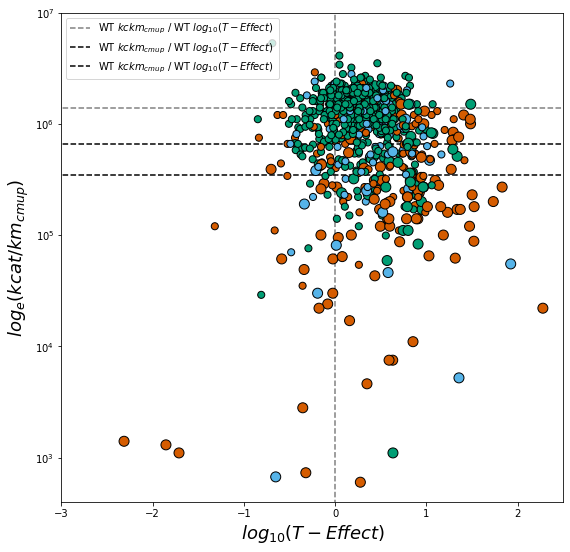

In [1050]:
fig,(ax2)=plt.subplots(1,1,figsize=(9,9))

idx = np.isfinite(kckm_df['TE_effects_G'].to_numpy().flatten()) & np.isfinite(kckm_df['kckm_cmup_G'].to_numpy().flatten()) & np.isfinite(kckm_df['to_G_class'].to_numpy().flatten())
pos=ax2.scatter(kckm_df['TE_effects_G'].to_numpy().flatten()[idx],kckm_df['kckm_cmup_G'].to_numpy()[idx],c=kckm_df['to_G_class'].to_numpy().flatten()[idx],s=kckm_df['TE_quality_37_G'].to_numpy()[idx],cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"] ), edgecolor='k')

idx = np.isfinite(kckm_df['TE_effects_V'].to_numpy().flatten()) & np.isfinite(kckm_df['kckm_cmup_V'].to_numpy().flatten()) & np.isfinite(kckm_df['to_V_class'].to_numpy().flatten())
#print(kckm_df['TE_quality_37_V'].to_numpy()[idx])
pos=ax2.scatter(kckm_df['TE_effects_V'].to_numpy().flatten()[idx],kckm_df['kckm_cmup_V'].to_numpy()[idx],c=kckm_df['to_V_class'].to_numpy().flatten()[idx],s=kckm_df['TE_quality_37_V'].to_numpy()[idx],cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"] ), edgecolor='k')

ax2.set_xlabel('$log_{10}(T-Effect)$',fontsize=18)
ax2.set_ylabel('$log_{e}(kcat/km_{cmup})$',fontsize=18)

ax2.plot([-100000,1e7],[1.4e6,1.4e6],c='gray',ls='--',zorder=-1,label='WT $kckm_{cmup}$ / WT $log_{10}(T-Effect)$ ')
ax2.plot([0,0],[0,1e8],c='gray',ls='--',zorder=-1)

ax2.plot([-100000,1e7],[66e4,66e4],c='k',ls='--',zorder=-1,label='WT $kckm_{cmup}$ / WT $log_{10}(T-Effect)$ ')
ax2.plot([-100000,1e7],[35e4,35e4],c='k',ls='--',zorder=-1,label='WT $kckm_{cmup}$ / WT $log_{10}(T-Effect)$ ')


ax2.set_xlim(-3,2.5)
ax2.set_ylim(400,1e7)

#ax2.set_xscale('symlog')
ax2.set_yscale('symlog')


#ax2.set_xscale('symlog
ax2.legend()

plt.savefig('./figures/kcat_km_cmup_TEffect_scatters_joint.pdf')

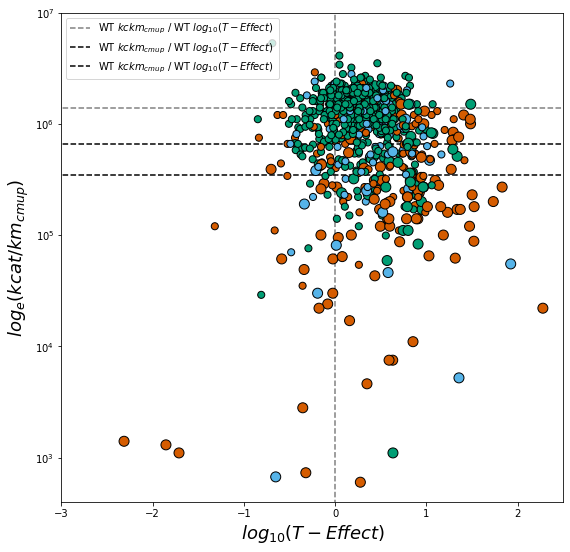

In [1051]:
fig,(ax2)=plt.subplots(1,1,figsize=(9,9))

idx = np.isfinite(kckm_df['TE_effects_G'].to_numpy().flatten()) & np.isfinite(kckm_df['kckm_cmup_G'].to_numpy().flatten()) & np.isfinite(kckm_df['to_G_class'].to_numpy().flatten())
pos=ax2.scatter(kckm_df['TE_effects_G'].to_numpy().flatten()[idx],kckm_df['kckm_cmup_G'].to_numpy()[idx],c=kckm_df['to_G_class'].to_numpy().flatten()[idx],s=kckm_df['TE_quality_37_G'].to_numpy()[idx],cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"] ), edgecolor='k')

idx = np.isfinite(kckm_df['TE_effects_V'].to_numpy().flatten()) & np.isfinite(kckm_df['kckm_cmup_V'].to_numpy().flatten()) & np.isfinite(kckm_df['to_V_class'].to_numpy().flatten())
#print(kckm_df['TE_quality_37_V'].to_numpy()[idx])
pos=ax2.scatter(kckm_df['TE_effects_V'].to_numpy().flatten()[idx],kckm_df['kckm_cmup_V'].to_numpy()[idx],c=kckm_df['to_V_class'].to_numpy().flatten()[idx],s=kckm_df['TE_quality_37_V'].to_numpy()[idx],cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"] ), edgecolor='k')

ax2.set_xlabel('$log_{10}(T-Effect)$',fontsize=18)
ax2.set_ylabel('$log_{e}(kcat/km_{cmup})$',fontsize=18)

ax2.plot([-100000,1e7],[1.4e6,1.4e6],c='gray',ls='--',zorder=-1,label='WT $kckm_{cmup}$ / WT $log_{10}(T-Effect)$ ')
ax2.plot([0,0],[0,1e8],c='gray',ls='--',zorder=-1)

ax2.plot([-100000,1e7],[66e4,66e4],c='k',ls='--',zorder=-1,label='WT $kckm_{cmup}$ / WT $log_{10}(T-Effect)$ ')
ax2.plot([-100000,1e7],[35e4,35e4],c='k',ls='--',zorder=-1,label='WT $kckm_{cmup}$ / WT $log_{10}(T-Effect)$ ')


ax2.set_xlim(-3,2.5)
ax2.set_ylim(400,1e7)

#ax2.set_xscale('symlog')
ax2.set_yscale('symlog')


#ax2.set_xscale('symlog
ax2.legend()

plt.savefig('./figures/kcat_km_cmup_TEffect_scatters_joint.pdf')

No handles with labels found to put in legend.


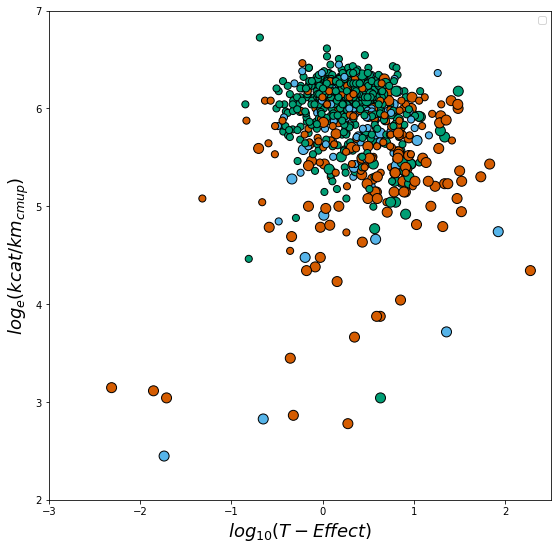

In [1055]:
fig,(ax2)=plt.subplots(1,1,figsize=(9,9))

te_unified=np.concatenate((kckm_df['TE_effects_V'].to_numpy().flatten(),kckm_df['TE_effects_G'].to_numpy().flatten()))
color_unified=np.concatenate((kckm_df['to_V_class'].to_numpy().flatten(),kckm_df['to_G_class'].to_numpy().flatten()))
cmup_unified=np.concatenate((kckm_df['kckm_cmup_V'].to_numpy().flatten(),kckm_df['kckm_cmup_G'].to_numpy().flatten()))
te_quality_unified=np.concatenate((kckm_df['TE_quality_37_V'].to_numpy().flatten(),kckm_df['TE_quality_37_G'].to_numpy().flatten()))

idx=np.isfinite(te_unified) & np.isfinite(cmup_unified) 
pos=ax2.scatter(te_unified[idx],np.log10(cmup_unified[idx]),c=color_unified[idx],s=te_quality_unified[idx],cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"] ), edgecolor='k')

ax2.set_xlabel('$log_{10}(T-Effect)$',fontsize=18)
ax2.set_ylabel('$log_{e}(kcat/km_{cmup})$',fontsize=18)

ax2.set_xlim(-3,2.5)
ax2.set_ylim(2,7)

#ax2.set_xscale('symlog')
#ax2.set_yscale('symlog')


#ax2.set_xscale('symlog
ax2.legend()

plt.savefig('./figures/kcat_km_cmup_TEffect_scatters_joint.pdf')

No handles with labels found to put in legend.


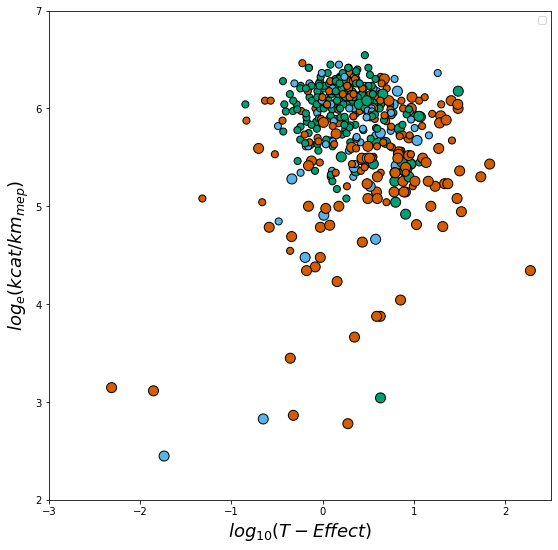

In [1096]:
fig,(ax2)=plt.subplots(1,1,figsize=(9,9))

te_unified=np.concatenate((kckm_df['TE_effects_V'].to_numpy().flatten(),kckm_df['TE_effects_G'].to_numpy().flatten()))
color_unified=np.concatenate((kckm_df['to_V_class'].to_numpy().flatten(),kckm_df['to_G_class'].to_numpy().flatten()))
cmup_unified=np.concatenate((kckm_df['kckm_cmup_V'].to_numpy().flatten(),kckm_df['kckm_cmup_G'].to_numpy().flatten()))
te_quality_unified=np.concatenate((kckm_df['TE_quality_37_V'].to_numpy().flatten(),kckm_df['TE_quality_37_G'].to_numpy().flatten()))
get_area_unified=np.concatenate((kckm_df['get_area'].to_numpy().flatten(),kckm_df['get_area'].to_numpy().flatten()))

idx=np.isfinite(te_unified) & np.isfinite(cmup_unified)  & (get_area_unified==0)
pos=ax2.scatter(te_unified[idx],np.log10(cmup_unified[idx]),c=color_unified[idx],s=te_quality_unified[idx],cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"] ), edgecolor='k')

ax2.set_xlabel('$log_{10}(T-Effect)$',fontsize=18)
ax2.set_ylabel('$log_{e}(kcat/km_{mep})$',fontsize=18)

ax2.set_xlim(-3,2.5)
ax2.set_ylim(2,7)

#ax2.set_xscale('symlog')
#ax2.set_yscale('symlog')


#ax2.set_xscale('symlog
ax2.legend()

plt.savefig('./figures/kcat_km_cmup_TEffect_scatters_joint.pdf')

No handles with labels found to put in legend.


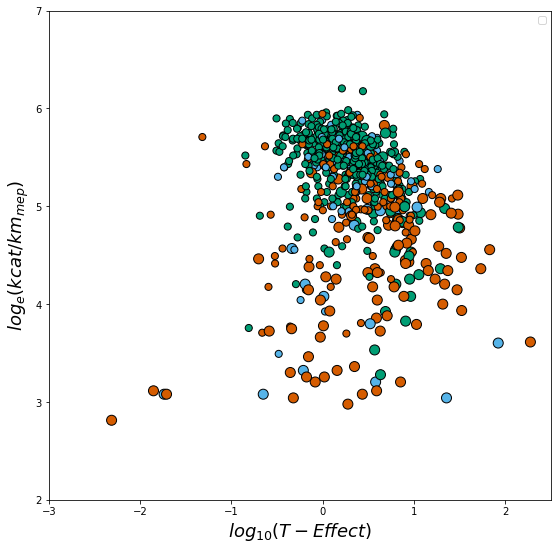

In [1056]:
fig,(ax2)=plt.subplots(1,1,figsize=(9,9))

te_unified=np.concatenate((kckm_df['TE_effects_V'].to_numpy().flatten(),kckm_df['TE_effects_G'].to_numpy().flatten()))
color_unified=np.concatenate((kckm_df['to_V_class'].to_numpy().flatten(),kckm_df['to_G_class'].to_numpy().flatten()))
cmup_unified=np.concatenate((kckm_df['kckm_cmup_V'].to_numpy().flatten(),kckm_df['kckm_cmup_G'].to_numpy().flatten()))
te_quality_unified=np.concatenate((kckm_df['TE_quality_37_V'].to_numpy().flatten(),kckm_df['TE_quality_37_G'].to_numpy().flatten()))

idx=np.isfinite(te_unified) & np.isfinite(mep_unified) 
pos=ax2.scatter(te_unified[idx],np.log10(mep_unified[idx]),c=color_unified[idx],s=te_quality_unified[idx],cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"] ), edgecolor='k')

ax2.set_xlabel('$log_{10}(T-Effect)$',fontsize=18)
ax2.set_ylabel('$log_{e}(kcat/km_{mep})$',fontsize=18)

ax2.set_xlim(-3,2.5)
ax2.set_ylim(2,7)

#ax2.set_xscale('symlog')
#ax2.set_yscale('symlog')


#ax2.set_xscale('symlog
ax2.legend()

plt.savefig('./figures/kcat_km_cmup_TEffect_scatters_joint.pdf')

In [193]:
count=0
for i in np.isfinite(te_unified) & np.isfinite(cmup_unified) & (te_unified>=1):
    if i:
        count+=1
print(count)

46


In [ ]:
fig,((ax2),(ax1))=plt.subplots(1,2,figsize=(14,6))

te_unified=np.concatenate((kckm_df['TE_effects_V'].to_numpy().flatten(),kckm_df['TE_effects_G'].to_numpy().flatten()))
color_unified=np.concatenate((kckm_df['to_V_class'].to_numpy().flatten(),kckm_df['to_G_class'].to_numpy().flatten()))
cmup_unified=np.concatenate((kckm_df['kckm_cmup_V'].to_numpy().flatten(),kckm_df['kckm_cmup_G'].to_numpy().flatten()))
te_quality_unified=np.concatenate((kckm_df['TE_quality_37_V'].to_numpy().flatten(),kckm_df['TE_quality_37_G'].to_numpy().flatten()))

idx=np.isfinite(te_unified) & np.isfinite(cmup_unified) & (te_unified>=1)
pos=ax2.scatter(te_unified[idx],np.log10(cmup_unified[idx]),c=color_unified[idx],s=te_quality_unified[idx],cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"] ), edgecolor='k')
idx=np.isfinite(te_unified) & np.isfinite(cmup_unified) & (te_unified<1)
pos=ax2.scatter(te_unified[idx],np.log10(cmup_unified[idx]),c='gray',s=te_quality_unified[idx], edgecolor='k',alpha=0.4)


idx = np.isfinite(te_unified) & np.isfinite(cmup_unified) & (te_unified>=1)
#print(te_quality_unified[idx],color_unified[idx],cmup_unified[idx])
pt.RainCloud(x=color_unified[idx],y=np.log10(cmup_unified[idx]),ax=ax1,orient='v',palette=['#009e74','#56b4e9','#d55c00'],bw=0.5,width_viol=0.5)

ax2.set_xlabel('$log_{10}(T-Effect)$',fontsize=18) 
ax2.set_ylabel('$log_{e}(kcat/km_{cmup})$',fontsize=18)
ax1.set_xticklabels(['WT-like','functional','total loss'],fontsize=14)
ax1.set_ylabel('$log_{e}(kcat/km_{cmup})$',fontsize=18)


ax2.plot([1,1],[0,8],c='k',ls='--',zorder=-1)
ax1.plot([-1,4],[np.log10(1.4e6),np.log10(1.4e6)],c='gray',ls='--',zorder=-1,label='WT $kckm_{cmup}$ / WT $log_{10}(T-Effect)$ ')


ax2.set_xlim(-3,2.5)
ax2.set_ylim(2,7)

#ax2.set_xscale('symlog')
#ax2.set_yscale('symlog')


#ax2.set_xscale('symlog
#ax2.legend()

plt.savefig('./figures/kcat_km_cmup_TEffect_over1.pdf')

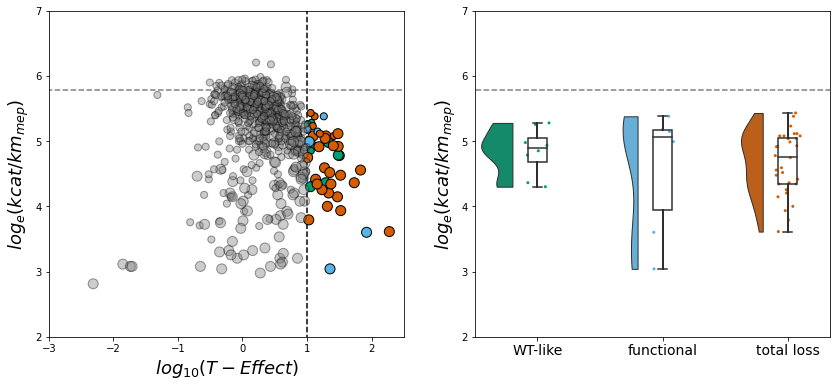

In [987]:
fig,((ax2),(ax1))=plt.subplots(1,2,figsize=(14,6))

te_unified=np.concatenate((kckm_df['TE_effects_V'].to_numpy().flatten(),kckm_df['TE_effects_G'].to_numpy().flatten()))
color_unified=np.concatenate((kckm_df['to_V_class'].to_numpy().flatten(),kckm_df['to_G_class'].to_numpy().flatten()))
cmup_unified=np.concatenate((kckm_df['kckm_cmup_V'].to_numpy().flatten(),kckm_df['kckm_cmup_G'].to_numpy().flatten()))
mep_unified=np.concatenate((kckm_df['kckm_mep_V'].to_numpy().flatten(),kckm_df['kckm_mep_G'].to_numpy().flatten()))
te_quality_unified=np.concatenate((kckm_df['TE_quality_37_V'].to_numpy().flatten(),kckm_df['TE_quality_37_G'].to_numpy().flatten()))

idx=np.isfinite(te_unified) & np.isfinite(mep_unified) & (te_unified>=1)
pos=ax2.scatter(te_unified[idx],np.log10(mep_unified[idx]),c=color_unified[idx],s=te_quality_unified[idx],cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"] ), edgecolor='k')
idx=np.isfinite(te_unified) & np.isfinite(mep_unified) & (te_unified<1)
pos=ax2.scatter(te_unified[idx],np.log10(mep_unified[idx]),c='gray',s=te_quality_unified[idx], edgecolor='k',alpha=0.4)


idx = np.isfinite(te_unified) & np.isfinite(mep_unified) & (te_unified>=1)
#print(te_quality_unified[idx],color_unified[idx],cmup_unified[idx])
pt.RainCloud(x=color_unified[idx],y=np.log10(mep_unified[idx]),ax=ax1,orient='v',palette=['#009e74','#56b4e9','#d55c00'],bw=0.5,width_viol=0.5)

ax2.set_xlabel('$log_{10}(T-Effect)$',fontsize=18) 
ax2.set_ylabel('$log_{e}(kcat/km_{mep})$',fontsize=18)
ax1.set_xticklabels(['WT-like','functional','total loss'],fontsize=14)
ax1.set_ylabel('$log_{e}(kcat/km_{mep})$',fontsize=18)


ax2.plot([1,1],[0,8],c='k',ls='--',zorder=-1)
ax1.plot([-1,4],[np.log10(6.1e5),np.log10(6.1e5)],c='gray',ls='--',zorder=-1,label='WT $kckm_{cmup}$ / WT $log_{10}(T-Effect)$ ')
ax2.plot([-6,4],[np.log10(6.1e5),np.log10(6.1e5)],c='gray',ls='--',zorder=-1,label='WT $kckm_{cmup}$ / WT $log_{10}(T-Effect)$ ')


ax2.set_xlim(-3,2.5)
ax2.set_ylim(2,7)
ax1.set_ylim(2,7)


#ax2.set_xscale('symlog')
#ax2.set_yscale('symlog')


#ax2.set_xscale('symlog
#ax2.legend()

plt.savefig('./figures/kcat_km_cmup_TEffect_over1.pdf')

In [988]:
idx = np.isfinite(te_unified) & np.isfinite(cmup_unified) & (te_unified>=1)
idx_no = np.isfinite(te_unified) & np.isfinite(cmup_unified)
length=len(list(color_unified))
print(list(color_unified[idx]).count(0)/list(color_unified[idx_no]).count(0),list(color_unified[idx]).count(1)/list(color_unified[idx_no]).count(1),list(color_unified[idx]).count(2)/list(color_unified[idx_no]).count(2))

0.016359918200409 0.06521739130434782 0.15763546798029557


In [1157]:
idx = np.isfinite(te_unified) & np.isfinite(mep_unified) & (te_unified>=1)
idx_no = np.isfinite(te_unified) & np.isfinite(mep_unified)
length=len(list(color_unified))
print(list(color_unified[idx]).count(0),list(color_unified[idx]).count(1),list(color_unified[idx]).count(2))

8 6 32


1300000.0
750000.0
405000.0


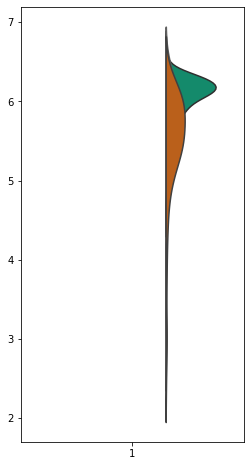

In [846]:
fig,((ax1))=plt.subplots(1,1,figsize=(4,8))

cmup_unified=np.concatenate((kckm_df['kckm_cmup_V'].to_numpy().flatten(),kckm_df['kckm_cmup_G'].to_numpy().flatten()))
print_unified=np.concatenate((kckm_df['print_group'].to_numpy().flatten(),kckm_df['print_group'].to_numpy().flatten()))
color_unified=np.concatenate((kckm_df['to_V_class'].to_numpy().flatten(),kckm_df['to_G_class'].to_numpy().flatten()))

idx = np.isfinite(te_unified) & np.isfinite(cmup_unified)   & (color_unified==0)
print(np.median(cmup_unified[idx]))
pt.half_violinplot(x=print_unified[idx],y=np.log10(cmup_unified[idx]),ax=ax1,orient='v',width=1*np.count_nonzero(idx)/len(idx),color='#009e74',
                   scale = "area", inner = None)

idx = np.isfinite(te_unified) & np.isfinite(cmup_unified)  & (color_unified==1)
print(np.median(cmup_unified[idx]))
pt.half_violinplot(x=print_unified[idx],y=np.log10(cmup_unified[idx]),ax=ax1,orient='v',width=1*np.count_nonzero(idx)/len(idx),color='#56b4e9',
                   scale = "area", inner = None)

idx = np.isfinite(te_unified) & np.isfinite(cmup_unified)   & (color_unified==2)
print(np.median(cmup_unified[idx]))
pt.half_violinplot(x=print_unified[idx],y=np.log10(cmup_unified[idx]),ax=ax1,orient='v',width=1*np.count_nonzero(idx)/len(idx),color='#d55c00',
                   scale = "area", inner = None)

# ax2.set_xlabel('$log_{10}(T-Effect)$ to G',fontsize=18)
# ax2.set_ylabel('$log_{e}(kcat/km_{cmup})$ to G',fontsize=18)

# ax2.plot([-100000,1e7],[1.4e6,1.4e6],c='gray',ls='--',zorder=-1,label='WT $kckm_{cmup}$ / WT $log_{10}(T-Effect)$ ')
# ax2.plot([0,0],[0,1e8],c='gray',ls='--',zorder=-1)


ax1.set_xlim(0.5,-0.5)

plt.savefig('./figures/kcat_km_joint_y_distributions.pdf')

0.33038900470186
0.43239600785618565
0.24983275863287413


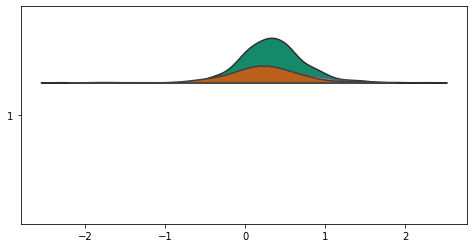

In [849]:
fig,((ax1))=plt.subplots(1,1,figsize=(8,4))

cmup_unified=np.concatenate((kckm_df['kckm_cmup_V'].to_numpy().flatten(),kckm_df['kckm_cmup_G'].to_numpy().flatten()))
te_unified=np.concatenate((kckm_df['TE_effects_G'].to_numpy().flatten(),kckm_df['TE_effects_V'].to_numpy().flatten()))
print_unified=np.concatenate((kckm_df['print_group'].to_numpy().flatten(),kckm_df['print_group'].to_numpy().flatten()))
color_unified=np.concatenate((kckm_df['to_V_class'].to_numpy().flatten(),kckm_df['to_G_class'].to_numpy().flatten()))

idx = np.isfinite(te_unified) & np.isfinite(cmup_unified)   & (color_unified==0)
print(np.median(te_unified[idx]))

pt.half_violinplot(y=print_unified[idx],x=te_unified[idx],ax=ax1,orient='h',width=1*np.count_nonzero(idx)/len(idx),color='#009e74',
                   scale = "area", inner = None)

idx = np.isfinite(te_unified) & np.isfinite(cmup_unified)   & (color_unified==1)
print(np.median(te_unified[idx]))
pt.half_violinplot(y=print_unified[idx],x=te_unified[idx],ax=ax1,orient='h',width=1*np.count_nonzero(idx)/len(idx),color='#56b4e9',
                   scale = "area", inner = None)

idx = np.isfinite(te_unified) & np.isfinite(cmup_unified)   & (color_unified==2)
print(np.median(te_unified[idx]))
pt.half_violinplot(y=print_unified[idx],x=te_unified[idx],ax=ax1,orient='h',width=1*np.count_nonzero(idx)/len(idx),color='#d55c00',
                   scale = "area", inner = None)

# ax2.set_xlabel('$log_{10}(T-Effect)$ to G',fontsize=18)
# ax2.set_ylabel('$log_{e}(kcat/km_{cmup})$ to G',fontsize=18)

# ax2.plot([-100000,1e7],[1.4e6,1.4e6],c='gray',ls='--',zorder=-1,label='WT $kckm_{cmup}$ / WT $log_{10}(T-Effect)$ ')
# ax2.plot([0,0],[0,1e8],c='gray',ls='--',zorder=-1)


#ax1.set_ylim(0.5,-0.5)

plt.savefig('./figures/kcat_km_joint_x_distributions.pdf')

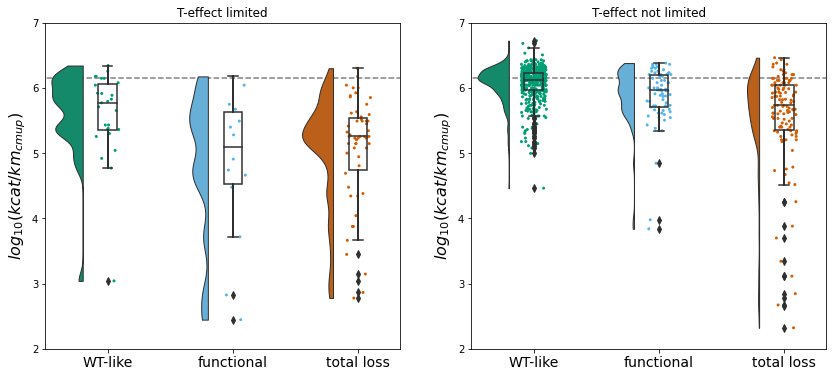

In [960]:
fig,((ax1),(ax2))=plt.subplots(1,2,figsize=(14,6))

te_unified=np.concatenate((kckm_df['TE_effects_G'].to_numpy().flatten(),kckm_df['TE_effects_V'].to_numpy().flatten()))
cmup_unified=np.concatenate((kckm_df['kckm_cmup_V'].to_numpy().flatten(),kckm_df['kckm_cmup_G'].to_numpy().flatten()))
color_unified=np.concatenate((kckm_df['to_V_class'].to_numpy().flatten(),kckm_df['to_G_class'].to_numpy().flatten()))
te_quality_unified=np.concatenate((kckm_df['TE_quality_37_V'].to_numpy().flatten(),kckm_df['TE_quality_37_G'].to_numpy().flatten()))
#print(te_quality_unified)

idx = np.isfinite(te_unified) & np.isfinite(cmup_unified) & (te_quality_unified==100)
#print(te_quality_unified[idx],color_unified[idx],cmup_unified[idx])
pt.RainCloud(x=color_unified[idx],y=np.log10(cmup_unified[idx]),ax=ax1,orient='v',width_viol=0.5,palette=['#009e74','#56b4e9','#d55c00'])

idx = np.isfinite(te_unified) & np.isfinite(cmup_unified) & (te_quality_unified==50)
pt.RainCloud(x=color_unified[idx],y=np.log10(cmup_unified[idx]),ax=ax2,orient='v',width_viol=0.5,palette=['#009e74','#56b4e9','#d55c00'])




ax1.plot([-1,3],[np.log10(1.4e6),np.log10(1.4e6)],c='gray',ls='--',zorder=-1,label='WT $kckm_{cmup}$ / WT $log_{10}(T-Effect)$ ')
ax2.plot([-1,3],[np.log10(1.4e6),np.log10(1.4e6)],c='gray',ls='--',zorder=-1,label='WT $kckm_{cmup}$ / WT $log_{10}(T-Effect)$ ')

ax1.set_ylim(2,7)
ax2.set_ylim(2,7)

ax1.set_title('T-effect limited')
ax2.set_title('T-effect not limited')

ax1.set_ylabel('$log_{10}(kcat/km_{cmup})$',fontsize=16)

ax2.set_ylabel('$log_{10}(kcat/km_{cmup})$',fontsize=16)

ax1.set_xticklabels(['WT-like','functional','total loss'],fontsize=14)
ax2.set_xticklabels(['WT-like','functional','total loss'],fontsize=14)


plt.savefig('./figures/kcat_km_TE_effect_limited_rainplot.pdf')

In [952]:
idx = np.isfinite(te_unified) & np.isfinite(cmup_unified) & (te_unified>=0.1)
idx_no = np.isfinite(te_unified) & np.isfinite(cmup_unified)
length=len(list(color_unified))
print(list(color_unified[idx]).count(0)/list(color_unified[idx_no]).count(0),list(color_unified[idx]).count(1)/list(color_unified[idx_no]).count(1),list(color_unified[idx]).count(2)/list(color_unified[idx_no]).count(2))

0.6912065439672802 0.75 0.7536945812807881


No handles with labels found to put in legend.


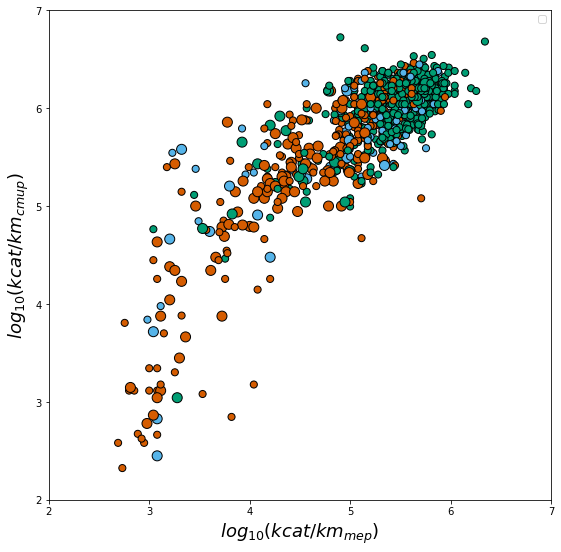

In [990]:
fig,((ax1))=plt.subplots(1,1,figsize=(9,9))

te_unified=np.concatenate((kckm_df['TE_effects_V'].to_numpy().flatten(),kckm_df['TE_effects_G'].to_numpy().flatten()))
color_unified=np.concatenate((kckm_df['to_V_class'].to_numpy().flatten(),kckm_df['to_G_class'].to_numpy().flatten()))
cmup_unified=np.concatenate((kckm_df['kckm_cmup_V'].to_numpy().flatten(),kckm_df['kckm_cmup_G'].to_numpy().flatten()))
mep_unified=np.concatenate((kckm_df['kckm_mep_V'].to_numpy().flatten(),kckm_df['kckm_mep_G'].to_numpy().flatten()))
te_quality_unified=np.concatenate((kckm_df['TE_quality_37_V'].to_numpy().flatten(),kckm_df['TE_quality_37_G'].to_numpy().flatten()))

idx=np.isfinite(mep_unified) & np.isfinite(cmup_unified)
pos=ax1.scatter(np.log10(mep_unified[idx]),np.log10(cmup_unified[idx]),c=color_unified[idx],s=te_quality_unified[idx],cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"] ), edgecolor='k')

ax1.set_xlabel('$log_{10}(kcat/km_{mep})$',fontsize=18)
ax1.set_ylabel('$log_{10}(kcat/km_{cmup})$',fontsize=18)

#ax1.set_xlim(-3,2.5)
ax1.set_ylim(2,7)
ax1.set_xlim(2,7)

#ax2.set_xscale('symlog')
#ax2.set_yscale('symlog')


#ax2.set_xscale('symlog
ax1.legend()

plt.savefig('./figures/kcat_km_cmup_TEffect_scatters_joint.pdf')

## in/out

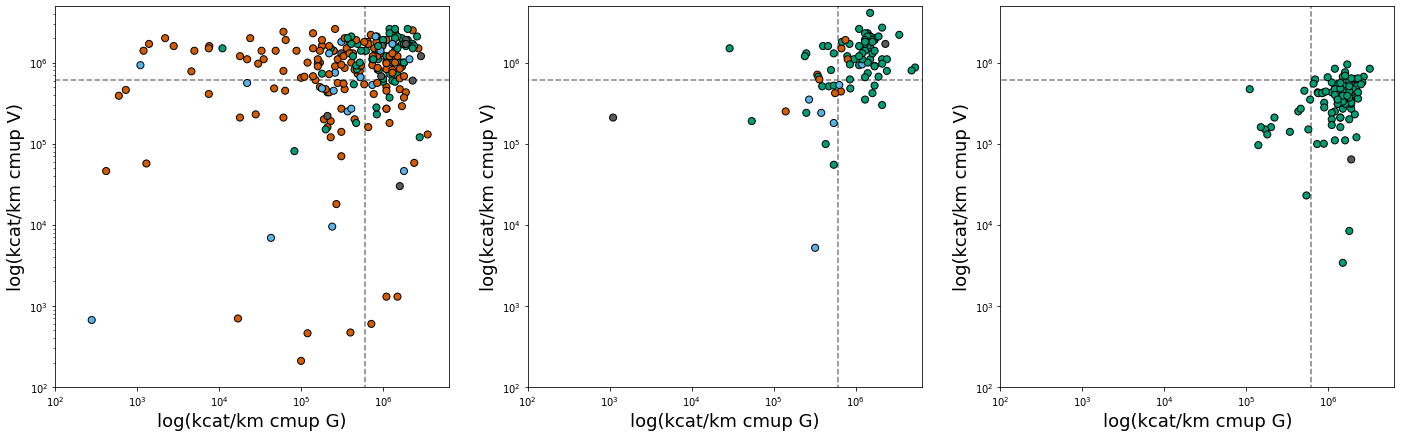

In [1086]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(24,7))

idx = np.isfinite(kckm_df['kckm_cmup_G'].to_numpy().flatten()) & np.isfinite(kckm_df['kckm_cmup_V'].to_numpy().flatten()) & (kckm_df['get_area'].to_numpy().flatten()==0)

pos=ax1.scatter(kckm_df['kckm_cmup_G'].to_numpy().flatten()[idx],kckm_df['kckm_cmup_V'].to_numpy()[idx],c=kckm_df['residue_class'].to_numpy().flatten()[idx],s=50,cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00","#5A5A5A","#5A5A5A","#5A5A5A"] ), edgecolor='k')

ax1.set_xlabel('log(kcat/km cmup G)',fontsize=18)
ax1.set_ylabel('log(kcat/km cmup V)',fontsize=18)

ax1.plot([-100000,1e7],[6.1e5,6.1e5],c='gray',ls='--',zorder=-1,label='WT kckm_cmup')
ax1.plot([6.1e5,6.1e5],[-100000,1e7],c='gray',ls='--',zorder=-1,label='WT kckm_cmup')

ax1.set_xlim(100,np.nanmax(kckm_df['kckm_cmup_G'].to_numpy())*1.2)
ax1.set_ylim(100,np.nanmax(kckm_df['kckm_cmup_V'].to_numpy())*1.2)

ax1.set_xscale('symlog')
ax1.set_yscale('log')

idx = np.isfinite(kckm_df['kckm_cmup_G'].to_numpy().flatten()) & np.isfinite(kckm_df['kckm_cmup_V'].to_numpy().flatten()) & (kckm_df['get_area'].to_numpy().flatten()==1)

pos=ax2.scatter(kckm_df['kckm_cmup_G'].to_numpy().flatten()[idx],kckm_df['kckm_cmup_V'].to_numpy()[idx],c=kckm_df['residue_class'].to_numpy().flatten()[idx],s=50,cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00","#5A5A5A","#5A5A5A","#5A5A5A"] ), edgecolor='k')

ax2.set_xlabel('log(kcat/km cmup G)',fontsize=18)
ax2.set_ylabel('log(kcat/km cmup V)',fontsize=18)

ax2.plot([-100000,1e7],[6.1e5,6.1e5],c='gray',ls='--',zorder=-1,label='WT kckm_cmup')
ax2.plot([6.1e5,6.1e5],[-100000,1e7],c='gray',ls='--',zorder=-1,label='WT kckm_cmup')

ax2.set_xlim(100,np.nanmax(kckm_df['kckm_cmup_G'].to_numpy())*1.2)
ax2.set_ylim(100,np.nanmax(kckm_df['kckm_cmup_V'].to_numpy())*1.2)

ax2.set_xscale('symlog')
ax2.set_yscale('symlog')

idx = np.isfinite(kckm_df['kckm_cmup_G'].to_numpy().flatten()) & np.isfinite(kckm_df['kckm_mep_V'].to_numpy().flatten()) & (kckm_df['get_area'].to_numpy().flatten()==2)

pos=ax3.scatter(kckm_df['kckm_cmup_G'].to_numpy().flatten()[idx],kckm_df['kckm_mep_V'].to_numpy()[idx],c=kckm_df['residue_class'].to_numpy().flatten()[idx],s=50,cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00","#5A5A5A","#5A5A5A","#5A5A5A"] ), edgecolor='k')

ax3.set_xlabel('log(kcat/km cmup G)',fontsize=18)
ax3.set_ylabel('log(kcat/km cmup V)',fontsize=18)

ax3.plot([-100000,1e7],[6.1e5,6.1e5],c='gray',ls='--',zorder=-1,label='WT kckm_cmup')
ax3.plot([6.1e5,6.1e5],[-100000,1e7],c='gray',ls='--',zorder=-1,label='WT kckm_cmup')

ax3.set_xlim(100,np.nanmax(kckm_df['kckm_cmup_G'].to_numpy())*1.2)
ax3.set_ylim(100,np.nanmax(kckm_df['kckm_cmup_V'].to_numpy())*1.2)

ax3.set_xscale('symlog')
ax3.set_yscale('symlog')



#plt.savefig('./figures/kcat_km_mep_cmup_scatters.pdf')

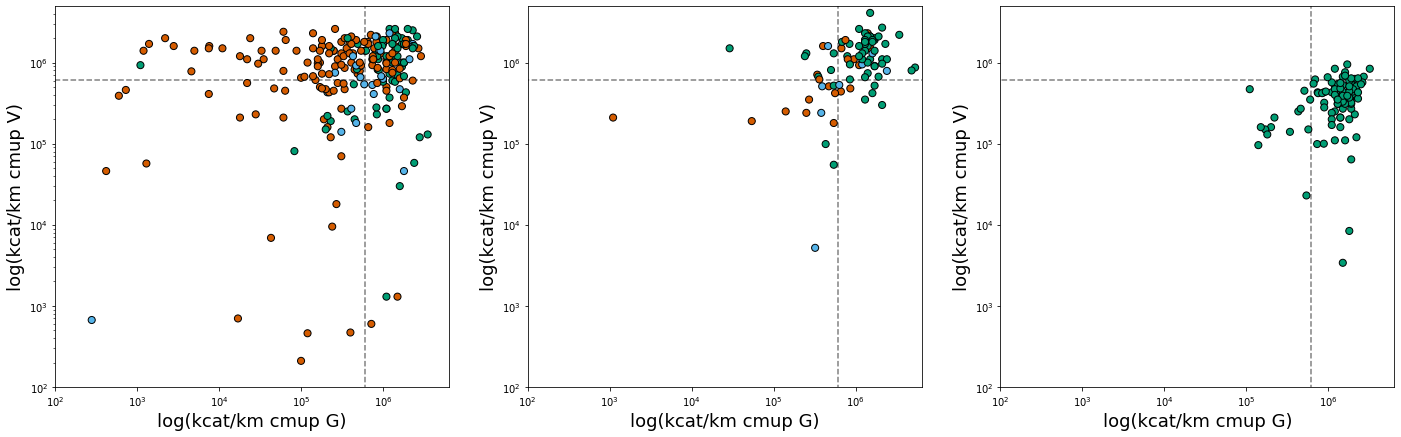

In [1090]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(24,7))

idx = np.isfinite(kckm_df['kckm_cmup_G'].to_numpy().flatten()) & np.isfinite(kckm_df['kckm_cmup_V'].to_numpy().flatten()) & (kckm_df['get_area'].to_numpy().flatten()==0)

pos=ax1.scatter(kckm_df['kckm_cmup_G'].to_numpy().flatten()[idx],kckm_df['kckm_cmup_V'].to_numpy()[idx],c=kckm_df['to_G_class'].to_numpy().flatten()[idx],s=50,cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"] ), edgecolor='k')

ax1.set_xlabel('log(kcat/km cmup G)',fontsize=18)
ax1.set_ylabel('log(kcat/km cmup V)',fontsize=18)

ax1.plot([-100000,1e7],[6.1e5,6.1e5],c='gray',ls='--',zorder=-1,label='WT kckm_cmup')
ax1.plot([6.1e5,6.1e5],[-100000,1e7],c='gray',ls='--',zorder=-1,label='WT kckm_cmup')

ax1.set_xlim(100,np.nanmax(kckm_df['kckm_cmup_G'].to_numpy())*1.2)
ax1.set_ylim(100,np.nanmax(kckm_df['kckm_cmup_V'].to_numpy())*1.2)

ax1.set_xscale('symlog')
ax1.set_yscale('log')

idx = np.isfinite(kckm_df['kckm_cmup_G'].to_numpy().flatten()) & np.isfinite(kckm_df['kckm_cmup_V'].to_numpy().flatten()) & (kckm_df['get_area'].to_numpy().flatten()==1)

pos=ax2.scatter(kckm_df['kckm_cmup_G'].to_numpy().flatten()[idx],kckm_df['kckm_cmup_V'].to_numpy()[idx],c=kckm_df['to_G_class'].to_numpy().flatten()[idx],s=50,cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"] ), edgecolor='k')

ax2.set_xlabel('log(kcat/km cmup G)',fontsize=18)
ax2.set_ylabel('log(kcat/km cmup V)',fontsize=18)

ax2.plot([-100000,1e7],[6.1e5,6.1e5],c='gray',ls='--',zorder=-1,label='WT kckm_cmup')
ax2.plot([6.1e5,6.1e5],[-100000,1e7],c='gray',ls='--',zorder=-1,label='WT kckm_cmup')

ax2.set_xlim(100,np.nanmax(kckm_df['kckm_cmup_G'].to_numpy())*1.2)
ax2.set_ylim(100,np.nanmax(kckm_df['kckm_cmup_V'].to_numpy())*1.2)

ax2.set_xscale('symlog')
ax2.set_yscale('symlog')

idx = np.isfinite(kckm_df['kckm_cmup_G'].to_numpy().flatten()) & np.isfinite(kckm_df['kckm_mep_V'].to_numpy().flatten()) & (kckm_df['get_area'].to_numpy().flatten()==2)

pos=ax3.scatter(kckm_df['kckm_cmup_G'].to_numpy().flatten()[idx],kckm_df['kckm_mep_V'].to_numpy()[idx],c=kckm_df['to_G_class'].to_numpy().flatten()[idx],s=50,cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"] ), edgecolor='k')

ax3.set_xlabel('log(kcat/km cmup G)',fontsize=18)
ax3.set_ylabel('log(kcat/km cmup V)',fontsize=18)

ax3.plot([-100000,1e7],[6.1e5,6.1e5],c='gray',ls='--',zorder=-1,label='WT kckm_cmup')
ax3.plot([6.1e5,6.1e5],[-100000,1e7],c='gray',ls='--',zorder=-1,label='WT kckm_cmup')

ax3.set_xlim(100,np.nanmax(kckm_df['kckm_cmup_G'].to_numpy())*1.2)
ax3.set_ylim(100,np.nanmax(kckm_df['kckm_cmup_V'].to_numpy())*1.2)

ax3.set_xscale('symlog')
ax3.set_yscale('symlog')



#plt.savefig('./figures/kcat_km_mep_cmup_scatters.pdf')

### paper figures

No handles with labels found to put in legend.


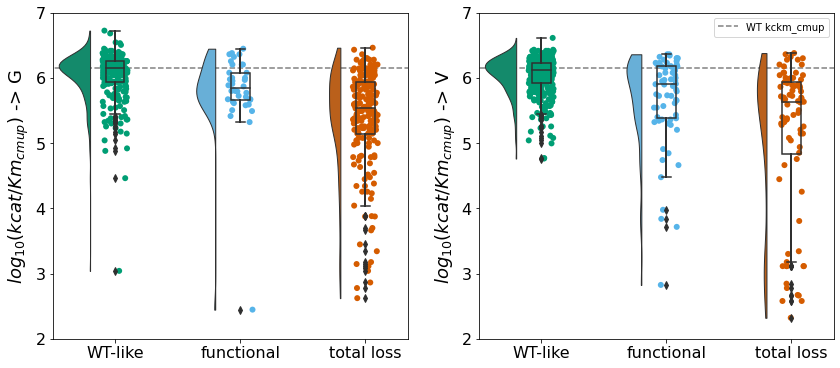

In [1147]:
#same thing with a single command: now x **must** be the categorical value
dx = "residue_class"; ort = "v"; pal = "Set2"; sigma = .3
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(14,6))


idx = np.isfinite(kckm_df['to_G_class'].to_numpy().flatten()) & np.isfinite(kckm_df['kckm_cmup_G'].to_numpy().flatten())
pt.RainCloud(x = kckm_df['to_G_class'][idx], y = np.log10(kckm_df['kckm_cmup_G'].to_numpy().flatten()[idx]), palette = ['#009e74','#56b4e9','#d55c00',"#5A5A5A"],
      bw = sigma,width_viol = .5, ax = ax0, orient = ort,point_size=6)

idx = np.isfinite(kckm_df['to_V_class'].to_numpy().flatten()) & np.isfinite(kckm_df['kckm_cmup_V'].to_numpy().flatten())
pt.RainCloud(x = kckm_df['to_V_class'][idx], y = np.log10(kckm_df['kckm_cmup_V'].to_numpy().flatten()[idx]), palette = ['#009e74','#56b4e9','#d55c00',"#5A5A5A"],
      bw = sigma,width_viol = .5, ax = ax1, orient = ort,point_size=6)
ax1.legend()

ax0.plot([-1,6],[np.log10(1.4e6),np.log10(1.4e6)],c='gray',ls='--',zorder=-1,label='WT kckm_cmup')
ax1.plot([-1,6],[np.log10(1.4e6),np.log10(1.4e6)],c='gray',ls='--',zorder=-1,label='WT kckm_cmup')

ax0.set_xticklabels(['WT-like','functional','total loss'])
ax1.set_xticklabels(['WT-like','functional','total loss'])

ax0.set_ylabel('$log_{10}(kcat/Km_{cmup})$ -> G',fontsize=18)
ax1.set_ylabel('$log_{10}(kcat/Km_{cmup})$ -> V',fontsize=18)

ax0.set_xlabel('')
ax1.set_xlabel('')

ax0.set_ylim(2,7)
ax1.set_ylim(2,7)

ax1.legend()

ax0.tick_params(axis='both', labelsize=16)
ax1.tick_params(axis='both', labelsize=16)



plt.savefig('./figures/Q9KJX5_kckm_cmup_var_violin.pdf',tight_layout=True)

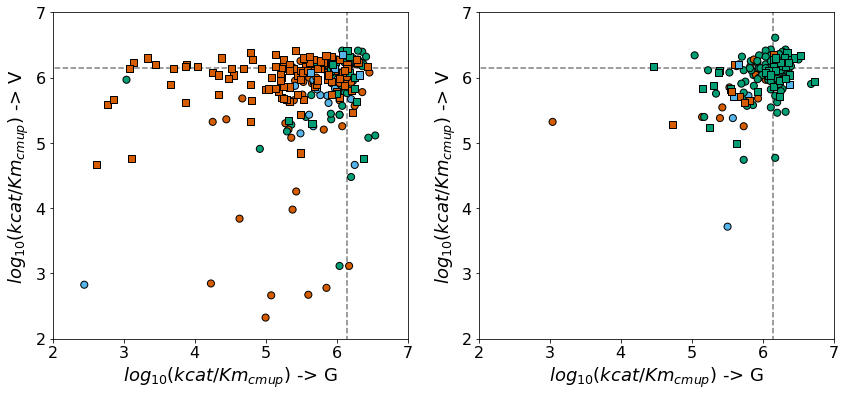

In [1154]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(14,6))

idx = np.isfinite(kckm_df['kckm_cmup_G'].to_numpy().flatten()) & np.isfinite(kckm_df['kckm_cmup_V'].to_numpy().flatten()) & (kckm_df['get_area'].to_numpy().flatten()==0) & (kckm_df['hydro_AA'].to_numpy().flatten()==1)
pos=ax1.scatter(np.log10(kckm_df['kckm_cmup_G'].to_numpy().flatten())[idx],np.log10(kckm_df['kckm_cmup_V'].to_numpy())[idx],c=kckm_df['to_G_class'].to_numpy().flatten()[idx],s=50,cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"] ), edgecolor='k')

idx = np.isfinite(kckm_df['kckm_cmup_G'].to_numpy().flatten()) & np.isfinite(kckm_df['kckm_cmup_V'].to_numpy().flatten()) & (kckm_df['get_area'].to_numpy().flatten()==0) & (kckm_df['hydro_AA'].to_numpy().flatten()==2)
pos=ax1.scatter(np.log10(kckm_df['kckm_cmup_G'].to_numpy().flatten()[idx]),np.log10(kckm_df['kckm_cmup_V'].to_numpy()[idx]),c=kckm_df['to_G_class'].to_numpy().flatten()[idx],s=50,cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"] ), edgecolor='k',marker='s')



idx = np.isfinite(kckm_df['kckm_cmup_G'].to_numpy().flatten()) & np.isfinite(kckm_df['kckm_cmup_V'].to_numpy().flatten()) & (kckm_df['get_area'].to_numpy().flatten()!=0) & (kckm_df['hydro_AA'].to_numpy().flatten()==1)
pos=ax2.scatter(np.log10(kckm_df['kckm_cmup_G'].to_numpy().flatten()[idx]),np.log10(kckm_df['kckm_cmup_V'].to_numpy()[idx]),c=kckm_df['to_G_class'].to_numpy().flatten()[idx],s=50,cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"] ), edgecolor='k')

idx = np.isfinite(kckm_df['kckm_cmup_G'].to_numpy().flatten()) & np.isfinite(kckm_df['kckm_cmup_V'].to_numpy().flatten()) & (kckm_df['get_area'].to_numpy().flatten()!=0) & (kckm_df['hydro_AA'].to_numpy().flatten()==2)
 
pos=ax2.scatter(np.log10(kckm_df['kckm_cmup_G'].to_numpy().flatten()[idx]),np.log10(kckm_df['kckm_cmup_V'].to_numpy()[idx]),c=kckm_df['to_G_class'].to_numpy().flatten()[idx],s=50,cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"] ), edgecolor='k',marker='s')

ax1.set_xlabel('$log_{10}(kcat/Km_{cmup})$ -> G',fontsize=18)
ax1.set_ylabel('$log_{10}(kcat/Km_{cmup})$ -> V',fontsize=18)
ax2.set_xlabel('$log_{10}(kcat/Km_{cmup})$ -> G',fontsize=18)
ax2.set_ylabel('$log_{10}(kcat/Km_{cmup})$ -> V',fontsize=18)


ax1.plot([-1,8],[np.log10(1.4e6),np.log10(1.4e6)],c='gray',ls='--',zorder=-1,label='WT kckm_cmup')
ax1.plot([np.log10(1.4e6),np.log10(1.4e6)],[-1,8],c='gray',ls='--',zorder=-1,label='WT kckm_cmup')

ax2.plot([-1,8],[np.log10(1.4e6),np.log10(1.4e6)],c='gray',ls='--',zorder=-1,label='WT kckm_cmup')
ax2.plot([np.log10(1.4e6),np.log10(1.4e6)],[-1,8],c='gray',ls='--',zorder=-1,label='WT kckm_cmup')

ax1.set_xlim(2,7)
ax1.set_ylim(2,7)
ax2.set_xlim(2,7)
ax2.set_ylim(2,7)

ax1.tick_params(axis='both', labelsize=16)
ax2.tick_params(axis='both', labelsize=16)
plt.savefig('./figures/kcat_km_cmup_v_s_scatters.pdf')

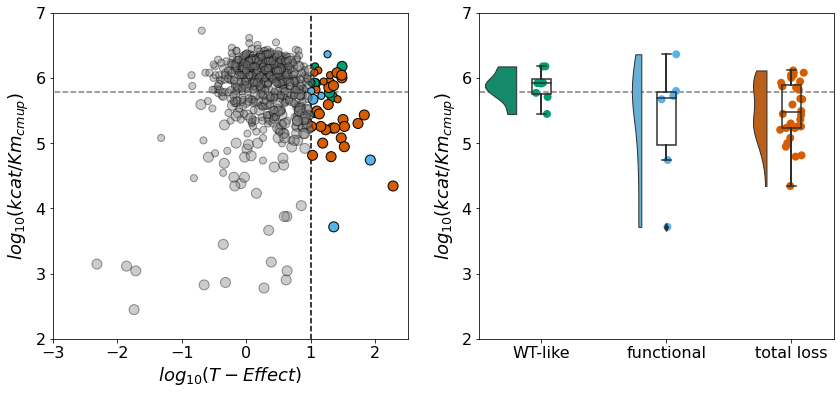

In [1156]:
fig,((ax2),(ax1))=plt.subplots(1,2,figsize=(14,6))

te_unified=np.concatenate((kckm_df['TE_effects_V'].to_numpy().flatten(),kckm_df['TE_effects_G'].to_numpy().flatten()))
color_unified=np.concatenate((kckm_df['to_V_class'].to_numpy().flatten(),kckm_df['to_G_class'].to_numpy().flatten()))
cmup_unified=np.concatenate((kckm_df['kckm_cmup_V'].to_numpy().flatten(),kckm_df['kckm_cmup_G'].to_numpy().flatten()))
mep_unified=np.concatenate((kckm_df['kckm_mep_V'].to_numpy().flatten(),kckm_df['kckm_mep_G'].to_numpy().flatten()))
te_quality_unified=np.concatenate((kckm_df['TE_quality_37_V'].to_numpy().flatten(),kckm_df['TE_quality_37_G'].to_numpy().flatten()))

idx=np.isfinite(te_unified) & np.isfinite(cmup_unified) & (te_unified>=1)
pos=ax2.scatter(te_unified[idx],np.log10(cmup_unified[idx]),c=color_unified[idx],s=te_quality_unified[idx],cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"] ), edgecolor='k')
idx=np.isfinite(te_unified) & np.isfinite(cmup_unified) & (te_unified<1)
pos=ax2.scatter(te_unified[idx],np.log10(cmup_unified[idx]),c='gray',s=te_quality_unified[idx], edgecolor='k',alpha=0.4)


idx = np.isfinite(te_unified) & np.isfinite(cmup_unified) & (te_unified>=1)
#print(te_quality_unified[idx],color_unified[idx],cmup_unified[idx])
pt.RainCloud(x=color_unified[idx],y=np.log10(cmup_unified[idx]),ax=ax1,orient='v',palette=['#009e74','#56b4e9','#d55c00'],bw=0.5,width_viol=0.5,point_size=8)

ax2.set_xlabel('$log_{10}(T-Effect)$',fontsize=18) 
ax2.set_ylabel('$log_{10}(kcat/Km_{cmup})$',fontsize=18)
ax1.set_xticklabels(['WT-like','functional','total loss'],fontsize=16)
ax1.set_ylabel('$log_{10}(kcat/Km_{cmup})$',fontsize=18)


ax2.plot([1,1],[0,8],c='k',ls='--',zorder=-1)
ax1.plot([-1,4],[np.log10(6.1e5),np.log10(6.1e5)],c='gray',ls='--',zorder=-1,label='WT $kckm_{cmup}$ / WT $log_{10}(T-Effect)$ ')
ax2.plot([-6,4],[np.log10(6.1e5),np.log10(6.1e5)],c='gray',ls='--',zorder=-1,label='WT $kckm_{cmup}$ / WT $log_{10}(T-Effect)$ ')


ax2.set_xlim(-3,2.5)
ax2.set_ylim(2,7)
ax1.set_ylim(2,7)

ax1.tick_params(axis='both', labelsize=16)
ax2.tick_params(axis='both', labelsize=16)

plt.savefig('./figures/kcat_km_cmup_TEffect_over1.pdf')